# ## 1. Setup and Global Config

In [1]:


import glob
import os
import time
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [2]:
# -----------------------------
# Global Config
# -----------------------------
# DATA_PATH    = "/kaggle/input/unb-cic-iot-dataset/wataiData/csv/CICIoT2023"
DATA_PATH    = r"C:\Users\ss160\Desktop\My_Code\PycharmProjects\Ciciot23_practical\dataset\wataiData\csv\CICIoT2023"
LABEL_COL    = "label"
TARGET_ROWS  = 5_000_000
MIN_SAMPLES  = 1_000
RANDOM_STATE = 42
CHUNK_SIZE   = 2_000_000
SUBSAMPLE_N  = 200_000
SAVE_DIR     = "figures_8"
FIG_DPI      = 600

os.makedirs(SAVE_DIR, exist_ok=True)
sns.set_style("whitegrid")
np.random.seed(RANDOM_STATE)

def _sanitize_name(name: str):
    return name.strip().lower().replace(" ", "_").replace("/", "_")

# ## 2. Load Files and Compute Original Distribution

In [3]:


csv_files = sorted(glob.glob(f"{DATA_PATH}/part-*.csv"))
assert csv_files, f"No files found in {DATA_PATH}"

header_df = pd.read_csv(csv_files[0], nrows=0)
ALL_FEATURES = [c for c in header_df.columns if c != LABEL_COL]

# Count labels
label_counts = Counter()
for path in tqdm(csv_files, desc="Counting labels"):
    for chunk in pd.read_csv(path, usecols=[LABEL_COL], chunksize=CHUNK_SIZE):
        label_counts.update(chunk[LABEL_COL].values)
total_rows = sum(label_counts.values())

Counting labels: 100%|██████████| 169/169 [01:02<00:00,  2.72it/s]


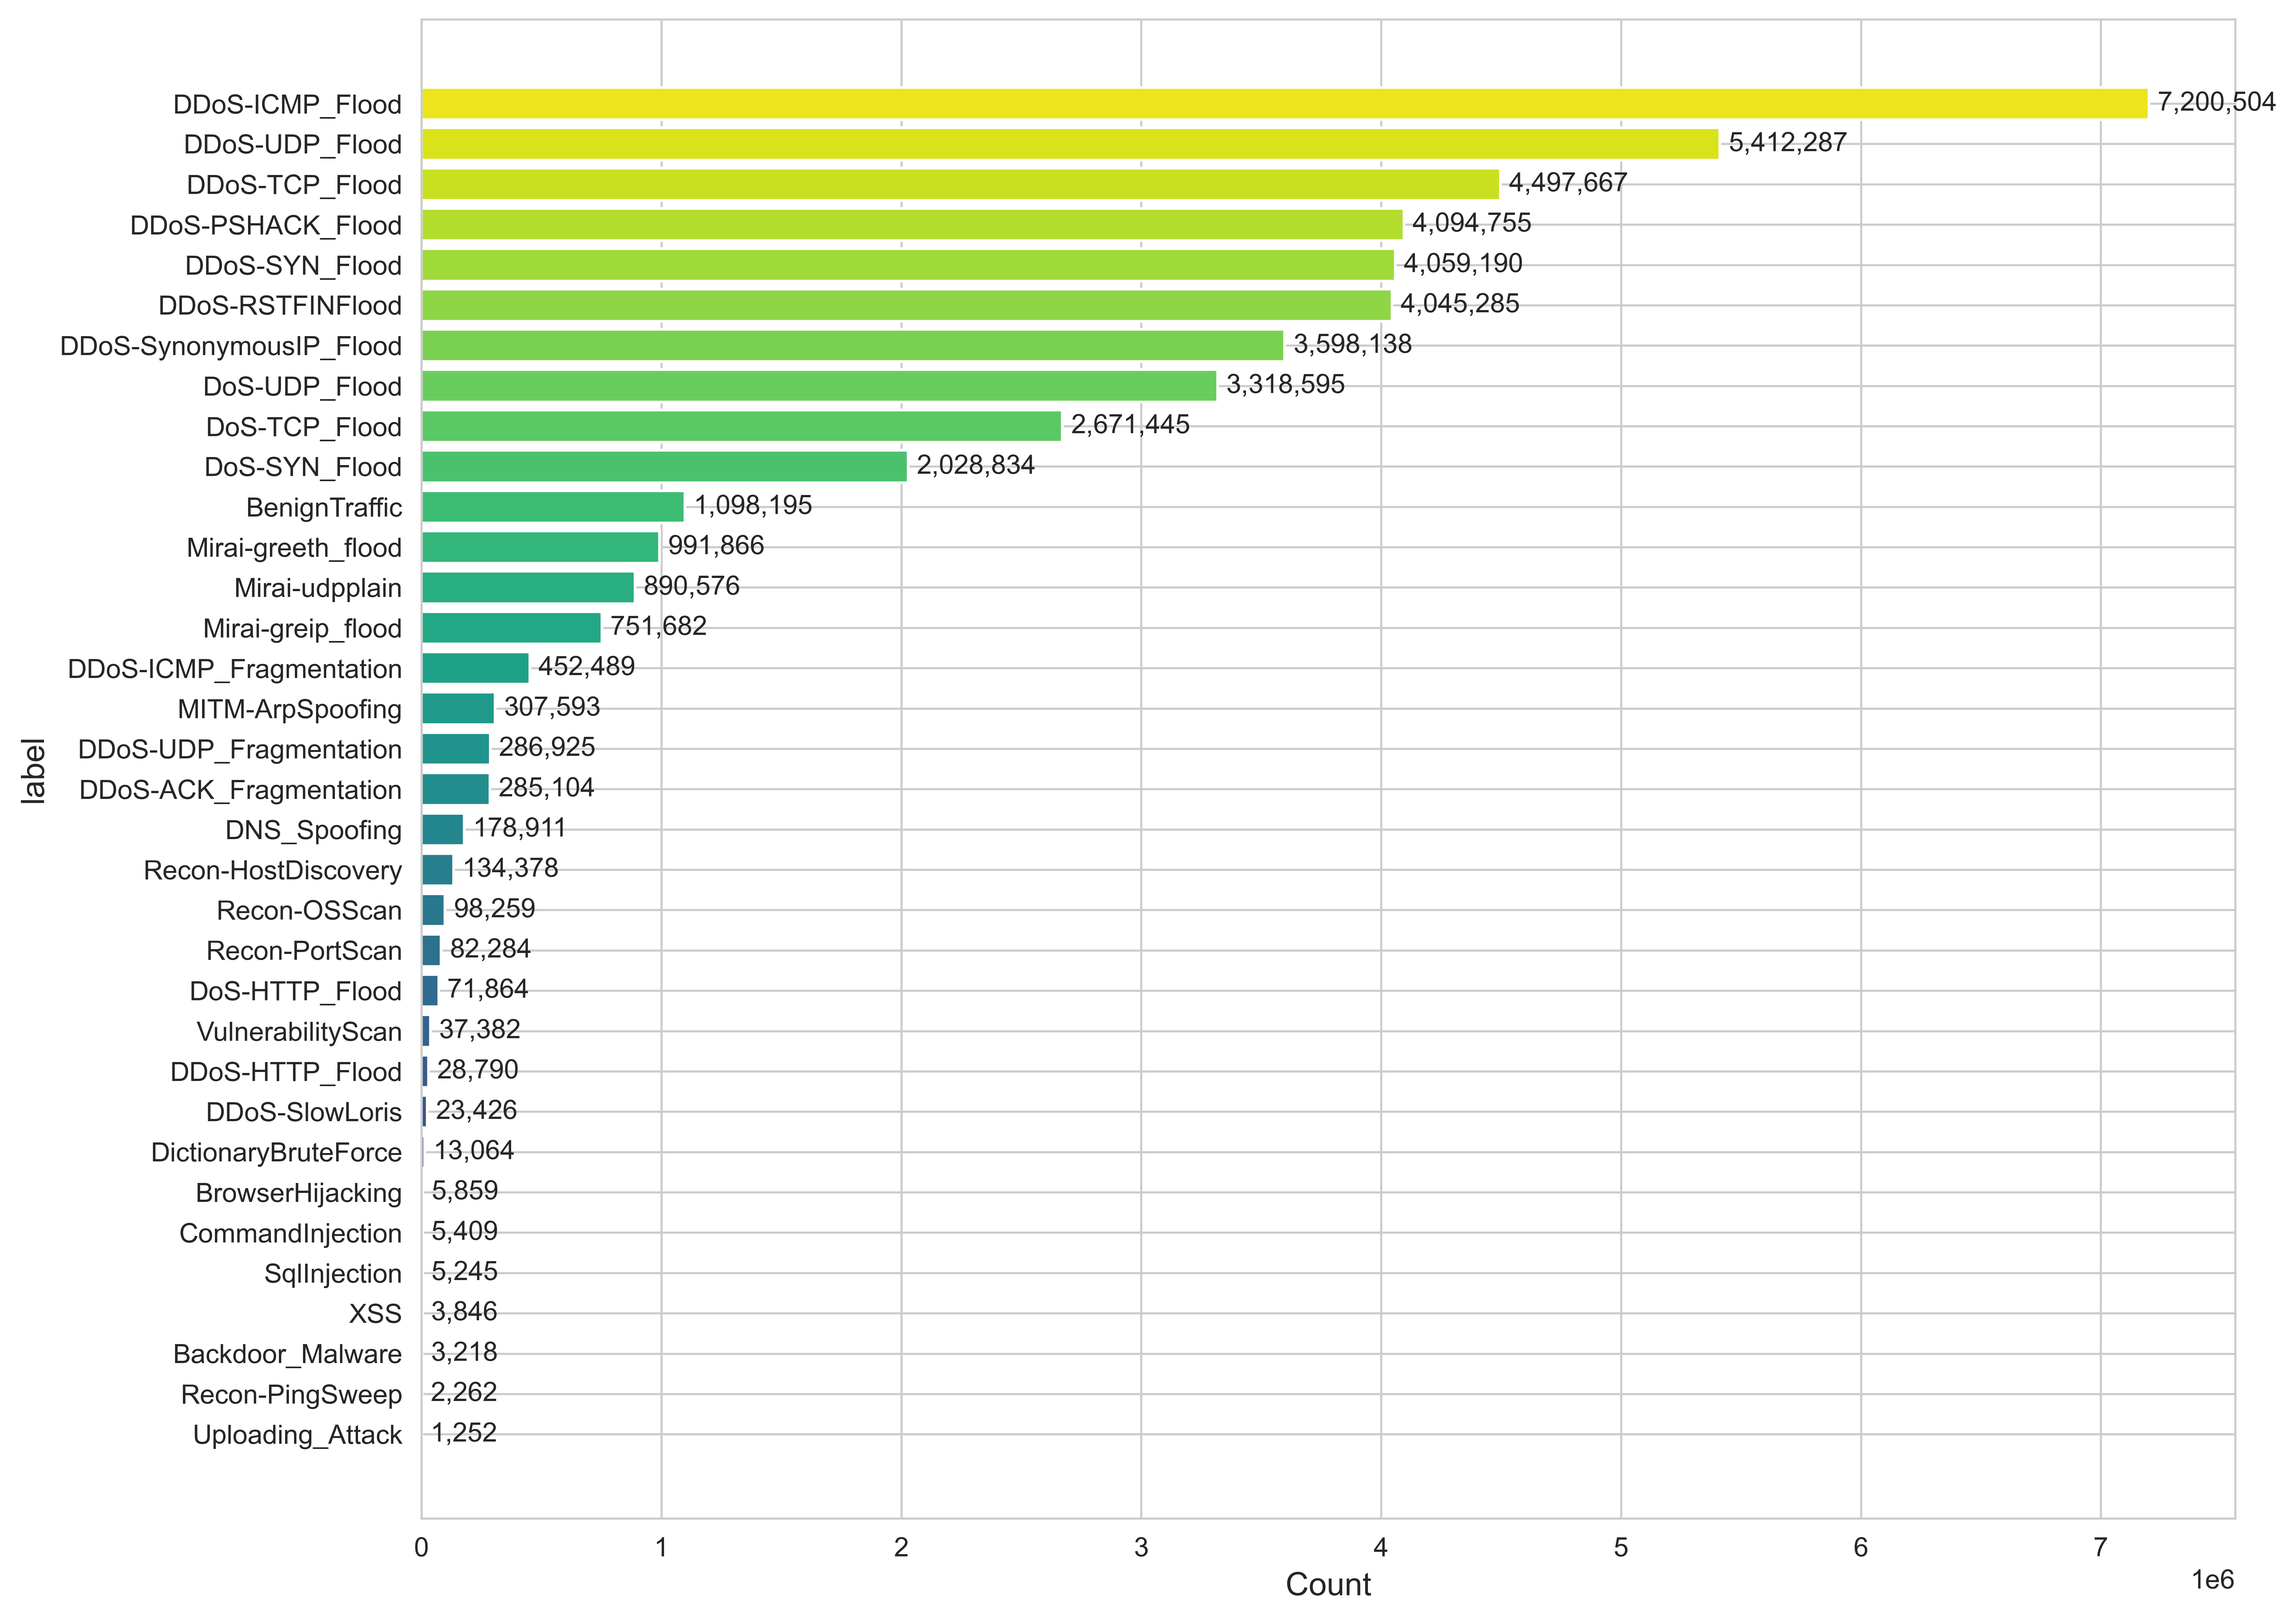

In [4]:
# ### Helper to plot and save counts

def plot_counts(counts_dict, filename, palette="viridis"):
    series = pd.Series(counts_dict).sort_values()
    fig_h = max(4, 0.25 * len(series))
    fig, ax = plt.subplots(figsize=(12, fig_h), dpi=FIG_DPI)
    colors = sns.color_palette(palette, len(series))
    ax.barh(series.index, series.values, color=colors)
    maxv = series.max()
    for i, v in enumerate(series.values):
        ax.text(v + maxv * 0.005, i, f"{v:,}", va="center", fontsize=10)
    ax.set_xlabel("Count", fontsize=12)
    ax.set_ylabel(LABEL_COL, fontsize=12)
    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, filename)
    plt.savefig(out_path, format="jpeg", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.02)
    plt.show()
    plt.close(fig)


plot_counts(label_counts, "original_label_distribution.jpeg", palette="viridis")

# ## 3. Stratified Undersampling and Label Mapping

Undersampling files:  81%|████████  | 137/169 [02:03<00:28,  1.11it/s]
C:\Users\ss160\AppData\Local\Temp\ipykernel_22672\44563337.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=frac, random_state=RANDOM_STATE))


→ Final sample size: 4,999,998


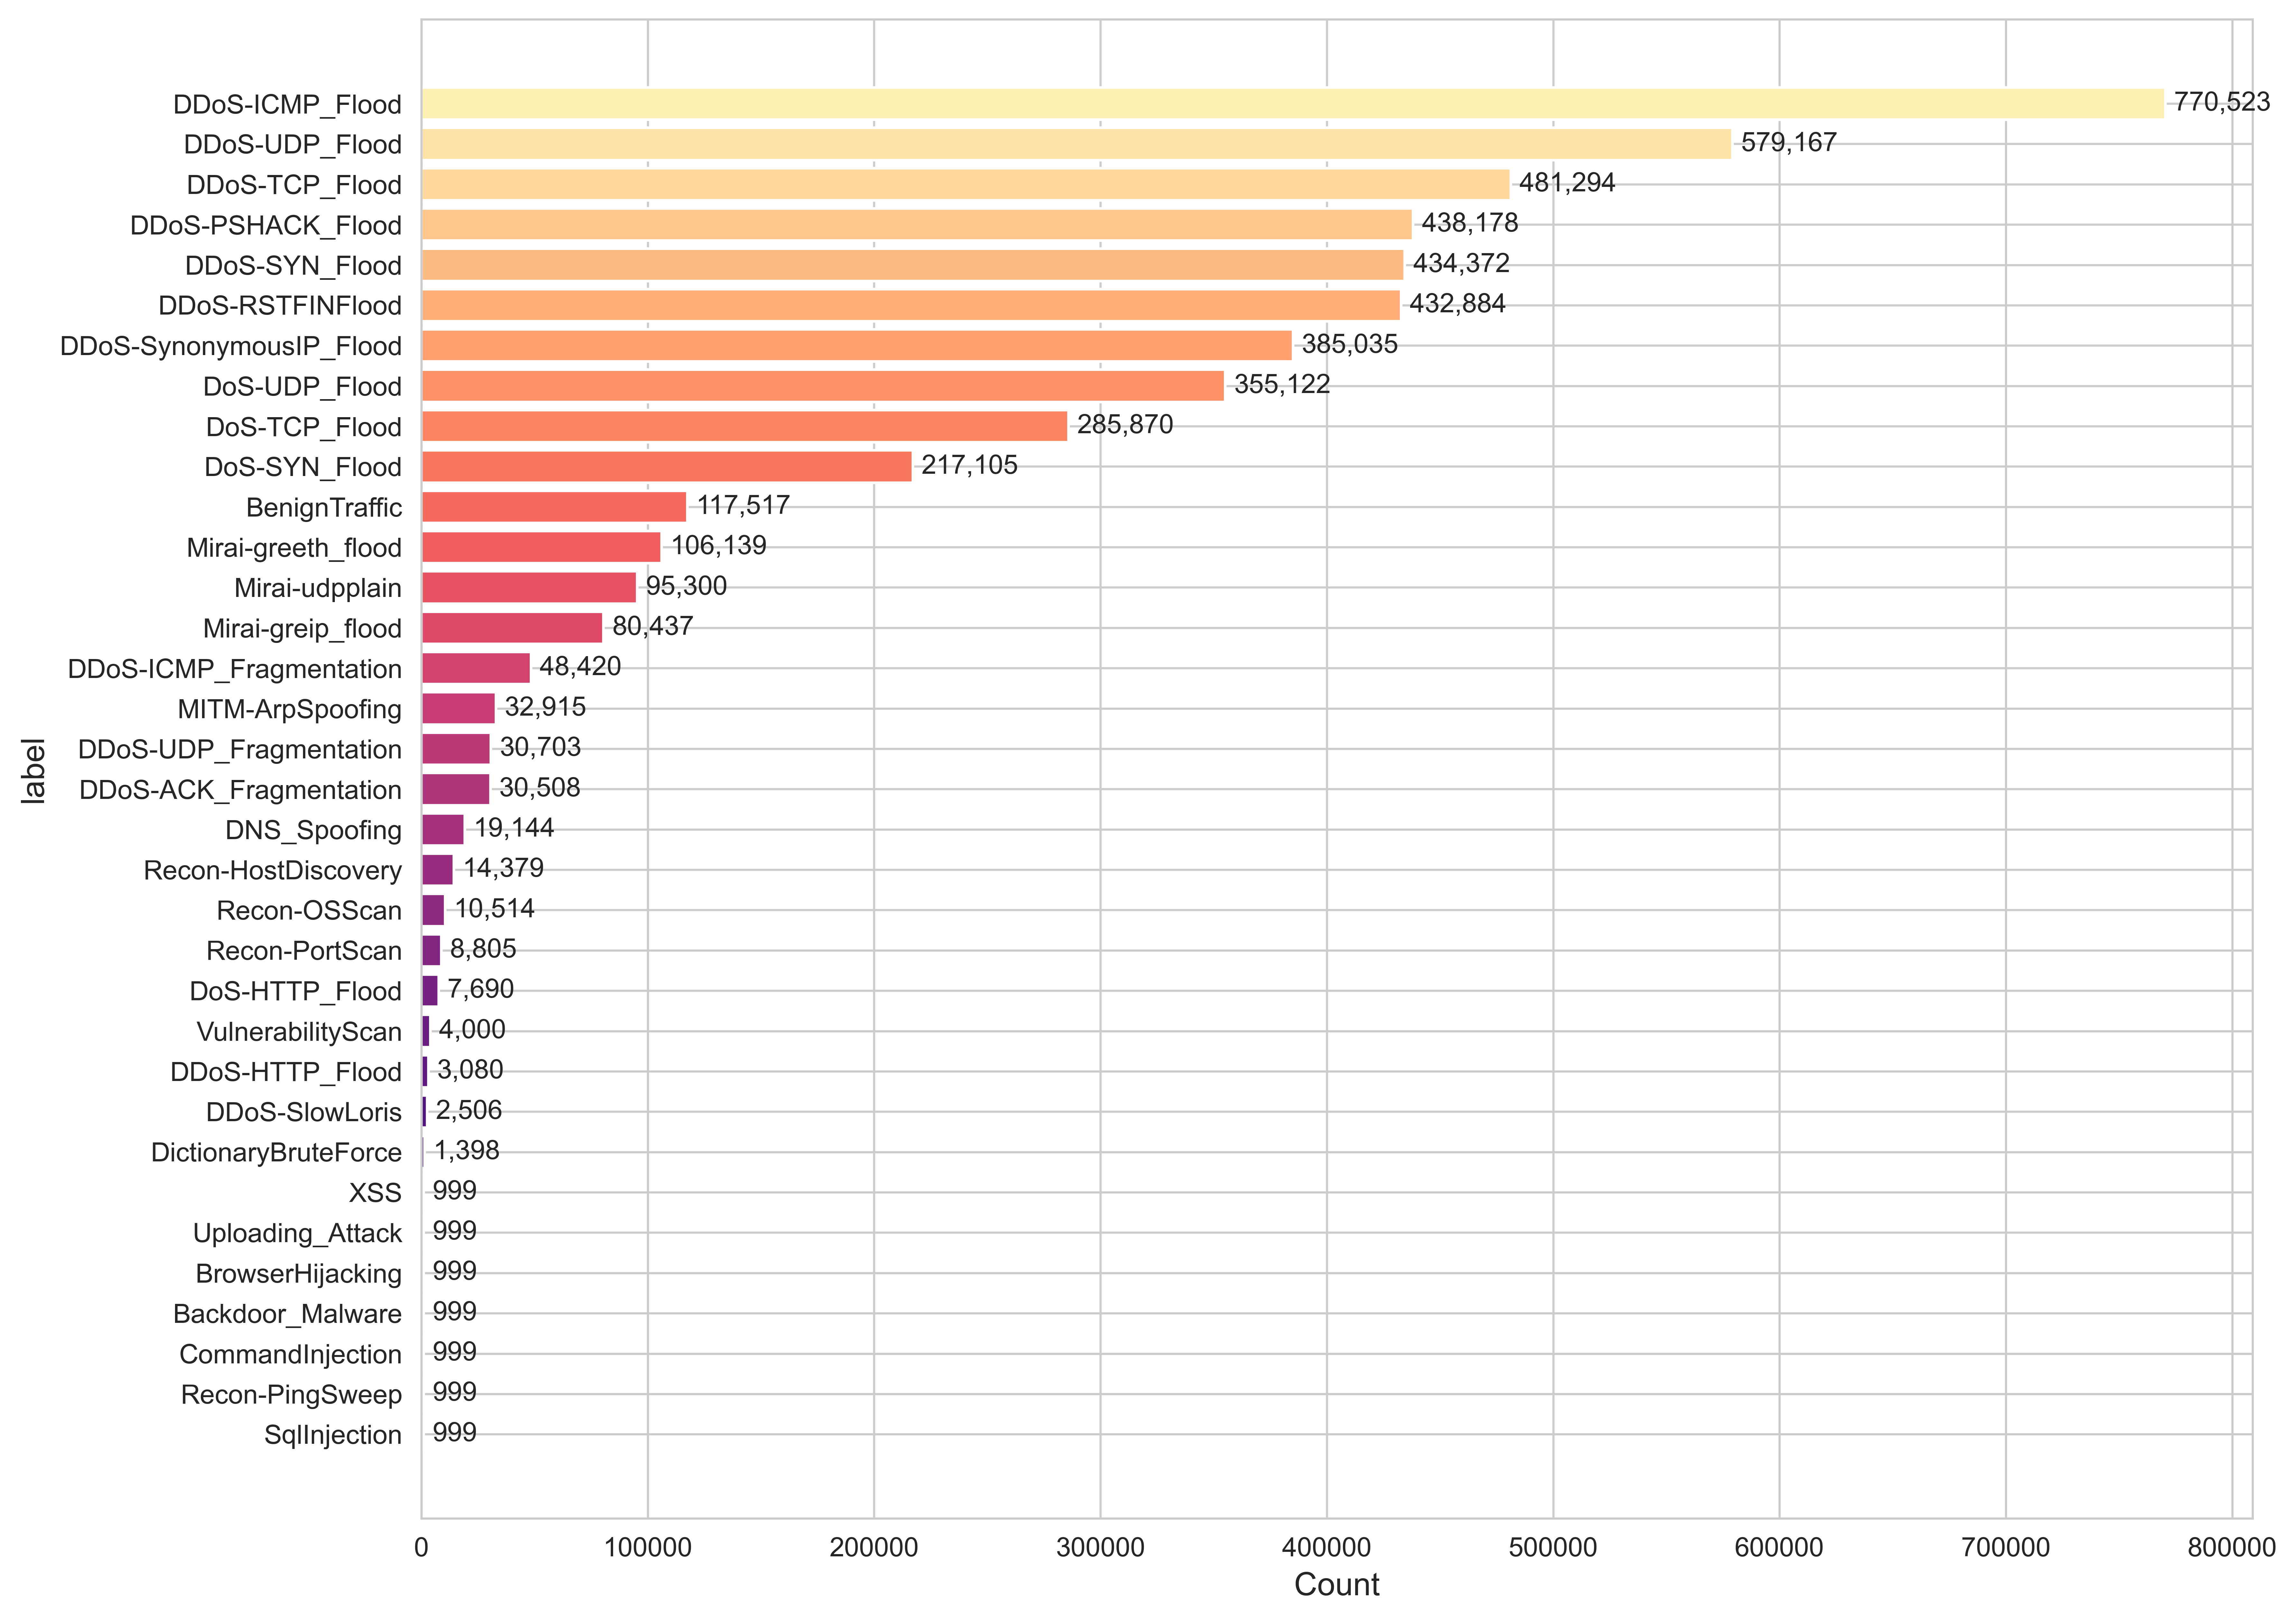

In [5]:


scaled = {lbl: max(1, int(cnt * TARGET_ROWS / total_rows)) for lbl, cnt in label_counts.items()}
target_counts = {lbl: max(MIN_SAMPLES, scaled[lbl]) for lbl in label_counts}

remaining = target_counts.copy()
selected_parts = []

for path in tqdm(csv_files, desc="Undersampling files"):
    if all(v <= 0 for v in remaining.values()):
        break
    for chunk in pd.read_csv(path, chunksize=CHUNK_SIZE):
        if all(v <= 0 for v in remaining.values()):
            break
        sub = chunk[chunk[LABEL_COL].isin([l for l, n in remaining.items() if n > 0])]
        if sub.empty: continue
        for lbl, need in list(remaining.items()):
            if need <= 0: continue
            idx = sub.index[sub[LABEL_COL] == lbl].to_numpy()
            if idx.size == 0: continue
            take = min(need, len(idx))
            chosen = np.random.choice(idx, size=take, replace=False)
            selected_parts.append(chunk.loc[chosen])
            remaining[lbl] -= take

reduced_df = pd.concat(selected_parts, ignore_index=True)
if len(reduced_df) > TARGET_ROWS:
    frac = TARGET_ROWS / len(reduced_df)
    reduced_df = (reduced_df.groupby(LABEL_COL, group_keys=False)
                  .apply(lambda g: g.sample(frac=frac, random_state=RANDOM_STATE))
                  .reset_index(drop=True))

print(f"→ Final sample size: {len(reduced_df):,}")
plot_counts(reduced_df[LABEL_COL].value_counts().to_dict(), "reduced_distribution.jpeg", palette="magma")


# ### Map labels to 8 categories

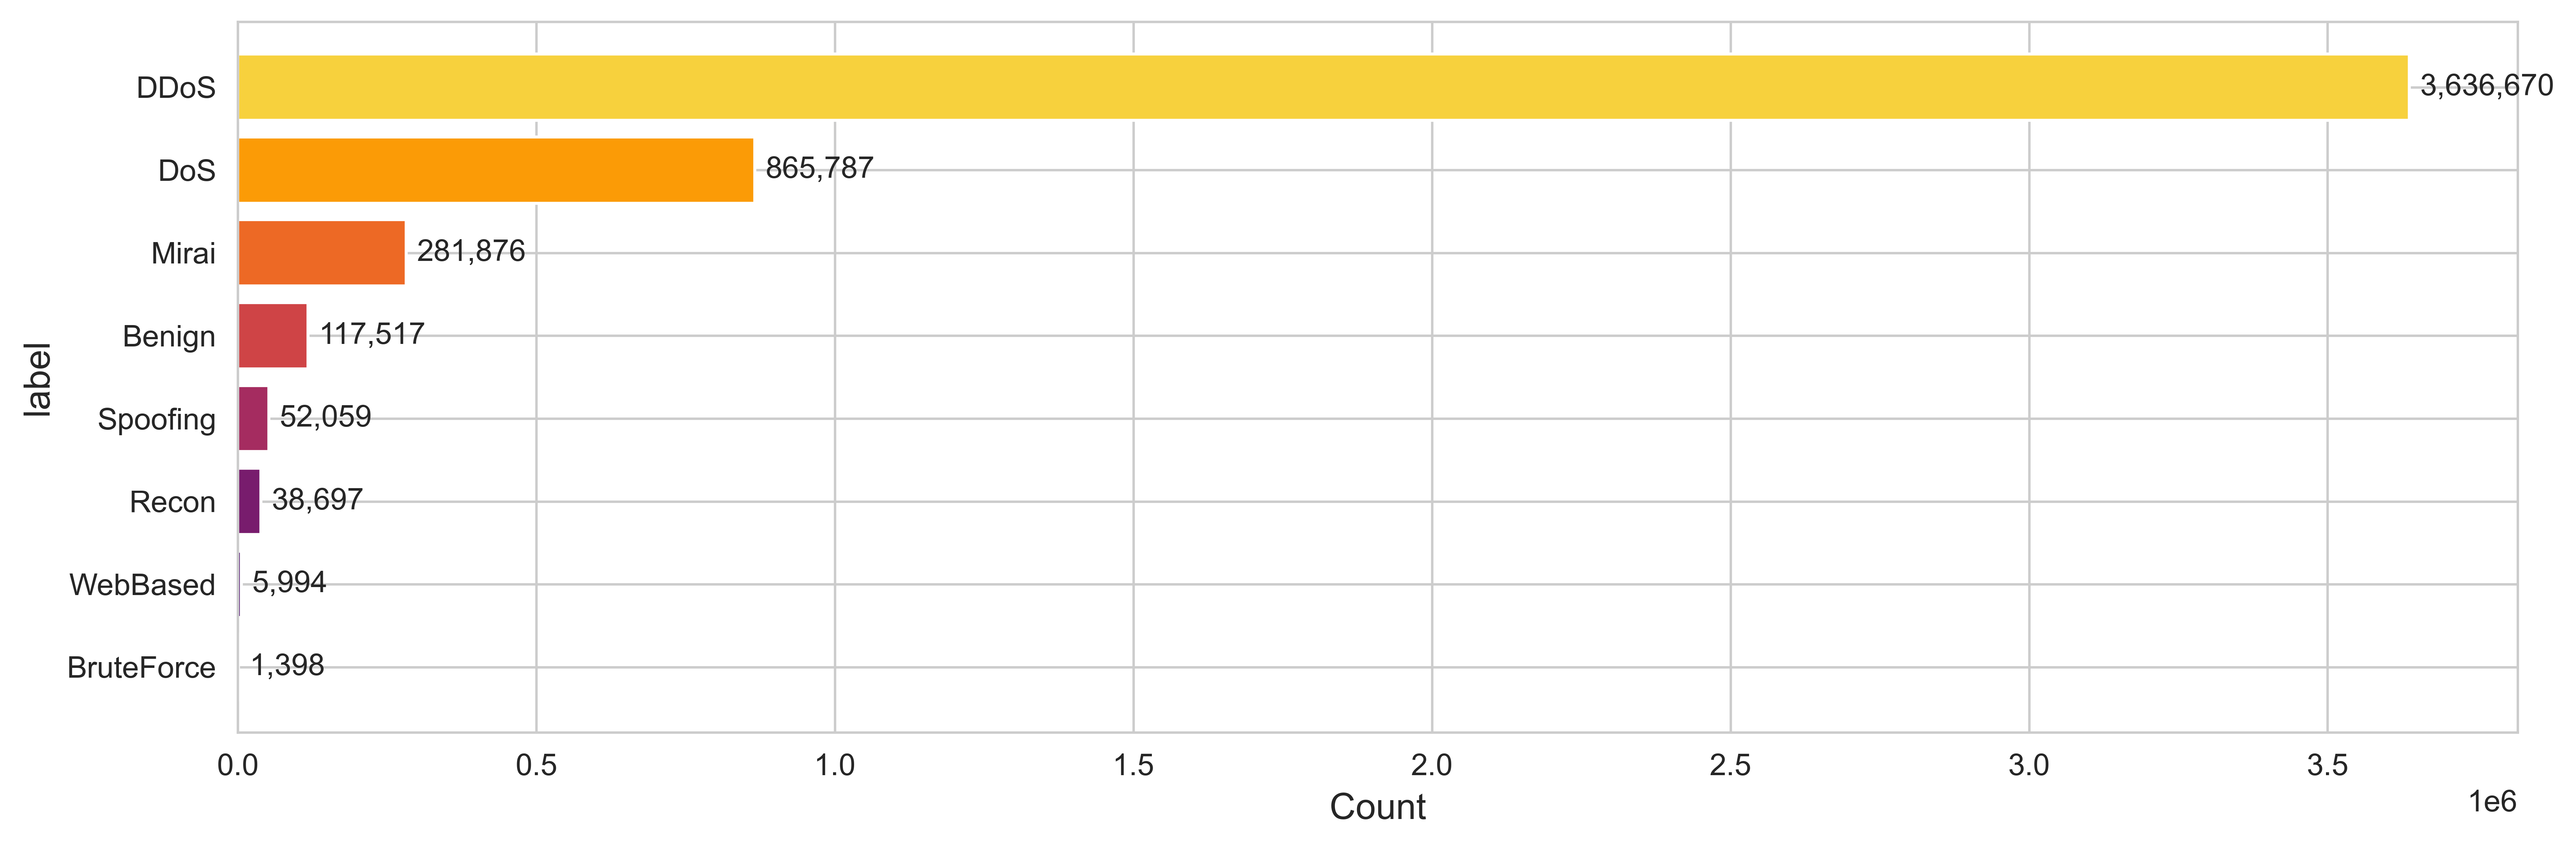

In [6]:


category_map = {}
category_map.update({lbl: "DDoS" for lbl in [
    "DDoS-ACK_Fragmentation", "DDoS-UDP_Flood", "DDoS-SlowLoris",
    "DDoS-ICMP_Flood", "DDoS-RSTFINFlood", "DDoS-PSHACK_Flood",
    "DDoS-HTTP_Flood", "DDoS-UDP_Fragmentation", "DDoS-ICMP_Fragmentation",
    "DDoS-TCP_Flood", "DDoS-SYN_Flood", "DDoS-SynonymousIP_Flood"
]})
category_map.update({lbl: "DoS" for lbl in [
    "DoS-TCP_Flood", "DoS-HTTP_Flood", "DoS-SYN_Flood", "DoS-UDP_Flood"
]})
category_map.update({lbl: "Recon" for lbl in [
    "Recon-PingSweep", "Recon-OSScan", "Recon-PortScan",
    "Recon-HostDiscovery", "VulnerabilityScan"
]})
category_map.update({lbl: "WebBased" for lbl in [
    "SqlInjection", "CommandInjection", "Backdoor_Malware",
    "Uploading_Attack", "XSS", "BrowserHijacking"
]})
category_map["DictionaryBruteForce"] = "BruteForce"
category_map["MITM-ArpSpoofing"] = "Spoofing"
category_map["DNS_Spoofing"] = "Spoofing"
category_map.update({lbl: "Mirai" for lbl in [
    "Mirai-greip_flood", "Mirai-greeth_flood", "Mirai-udpplain"
]})
category_map["BenignTraffic"] = "Benign"

reduced_df[LABEL_COL] = reduced_df[LABEL_COL].map(category_map)
reduced_df = reduced_df.dropna(subset=[LABEL_COL])
label_counts = reduced_df[LABEL_COL].value_counts().to_dict()
plot_counts(label_counts, "mapped_8class_distribution.jpeg", palette="inferno")

# ## 4. Feature Selection via LightGBM

In [7]:


fs_df = reduced_df.sample(n=min(len(reduced_df), SUBSAMPLE_N), random_state=RANDOM_STATE)
label_map = {lbl: i for i, lbl in enumerate(sorted(label_counts))}
fs_df["y_num"] = fs_df[LABEL_COL].map(label_map)
X_fs = fs_df[ALL_FEATURES]
y_fs = fs_df["y_num"]
lgb_train = lgb.Dataset(X_fs, label=y_fs, free_raw_data=False)

fs_params = {
    "objective": "multiclass",
    "num_class": len(label_map),
    "learning_rate": 0.1,
    "num_leaves": 31,
    "min_data_in_leaf": 100,
    "verbosity": -1,
    "seed": RANDOM_STATE,
}
fs_model = lgb.train(fs_params, lgb_train, num_boost_round=100,
                     valid_sets=[lgb_train],
                     callbacks=[lgb.early_stopping(10), lgb.log_evaluation(50)])

imp = pd.Series(fs_model.feature_importance("gain"), index=ALL_FEATURES)
thr = imp.median()
selected_feats = imp[imp > thr].index.tolist()
print(f"→ Selected {len(selected_feats)} / {len(ALL_FEATURES)} features")

C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\callback.py:347: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


[50]	training's multi_logloss: 0.252391
[100]	training's multi_logloss: 0.554557
→ Selected 23 / 46 features


In [8]:
# ## 5. Train/Test Split & Preprocessing

reduced_df = reduced_df[reduced_df[LABEL_COL].isin(label_map)]
y_full = reduced_df[LABEL_COL].map(label_map).values
X_full = reduced_df[selected_feats].values
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full,
                                                    random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_counts = Counter(y_train)
n_classes = len(label_map)
spw = [len(y_train) / (n_classes * train_counts[c]) for c in range(n_classes)]
wts = [spw[label] for label in y_train]
classes = [lbl for lbl, _ in sorted(label_map.items(), key=lambda x: x[1])]


# ## Helper Functions for Reports & Confusion Matrix

In [9]:


def save_classification_report_as_image(report_text, model_name):
    lines = report_text.strip().split("\n")
    max_line_len = max(len(line) for line in lines)
    fig_w = max(6, max_line_len * 0.065)
    fig_h = max(1.5, len(lines) * 0.32)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=FIG_DPI)
    ax.axis("off")
    ax.text(0, 1, report_text, fontsize=10, va="top", ha="left", family="monospace")
    out_path = os.path.join(SAVE_DIR, f"classification_report_{_sanitize_name(model_name)}.jpeg")
    plt.savefig(out_path, format="jpeg", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.01)
    plt.show()
    plt.close(fig)


def save_confusion_matrix(cm, model_name, classes, cmap="Blues"):
    n = len(classes)
    base = max(6, n * 0.3)
    fig, ax = plt.subplots(figsize=(base, base), dpi=FIG_DPI)
    cax = ax.matshow(cm, cmap=cmap)
    fig.colorbar(cax)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(classes, rotation=90, fontsize=6)
    ax.set_yticklabels(classes, fontsize=6)
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, f"{v:,}", ha="center", va="center", fontsize=6)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.tight_layout()
    out_path = os.path.join(SAVE_DIR, f"confusion_matrix_{_sanitize_name(model_name)}.jpeg")
    plt.savefig(out_path, format="jpeg", dpi=FIG_DPI, bbox_inches="tight", pad_inches=0.02)
    plt.show()
    plt.close(fig)

# ## 6. Train and Evaluate Models

Training XGBoost...


C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:05:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.70102
[50]	validation_0-mlogloss:0.02420
[100]	validation_0-mlogloss:0.01351
[150]	validation_0-mlogloss:0.01205
[200]	validation_0-mlogloss:0.01148
[250]	validation_0-mlogloss:0.01119
[300]	validation_0-mlogloss:0.01107
[350]	validation_0-mlogloss:0.01103
[400]	validation_0-mlogloss:0.01105
[450]	validation_0-mlogloss:0.01114
[499]	validation_0-mlogloss:0.01129


C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:729: UserWarning: [20:07:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


XGBoost Accuracy: 0.995922
              precision    recall  f1-score   support

      Benign     0.9356    0.9603    0.9478     23503
  BruteForce     0.8984    0.6000    0.7195       280
        DDoS     0.9999    0.9998    0.9998    727334
         DoS     0.9991    0.9997    0.9994    173158
       Mirai     1.0000    0.9999    0.9999     56375
       Recon     0.8594    0.8619    0.8606      7739
    Spoofing     0.9053    0.8704    0.8875     10412
    WebBased     0.7568    0.6772    0.7148      1199

    accuracy                         0.9959   1000000
   macro avg     0.9193    0.8711    0.8912   1000000
weighted avg     0.9959    0.9959    0.9959   1000000



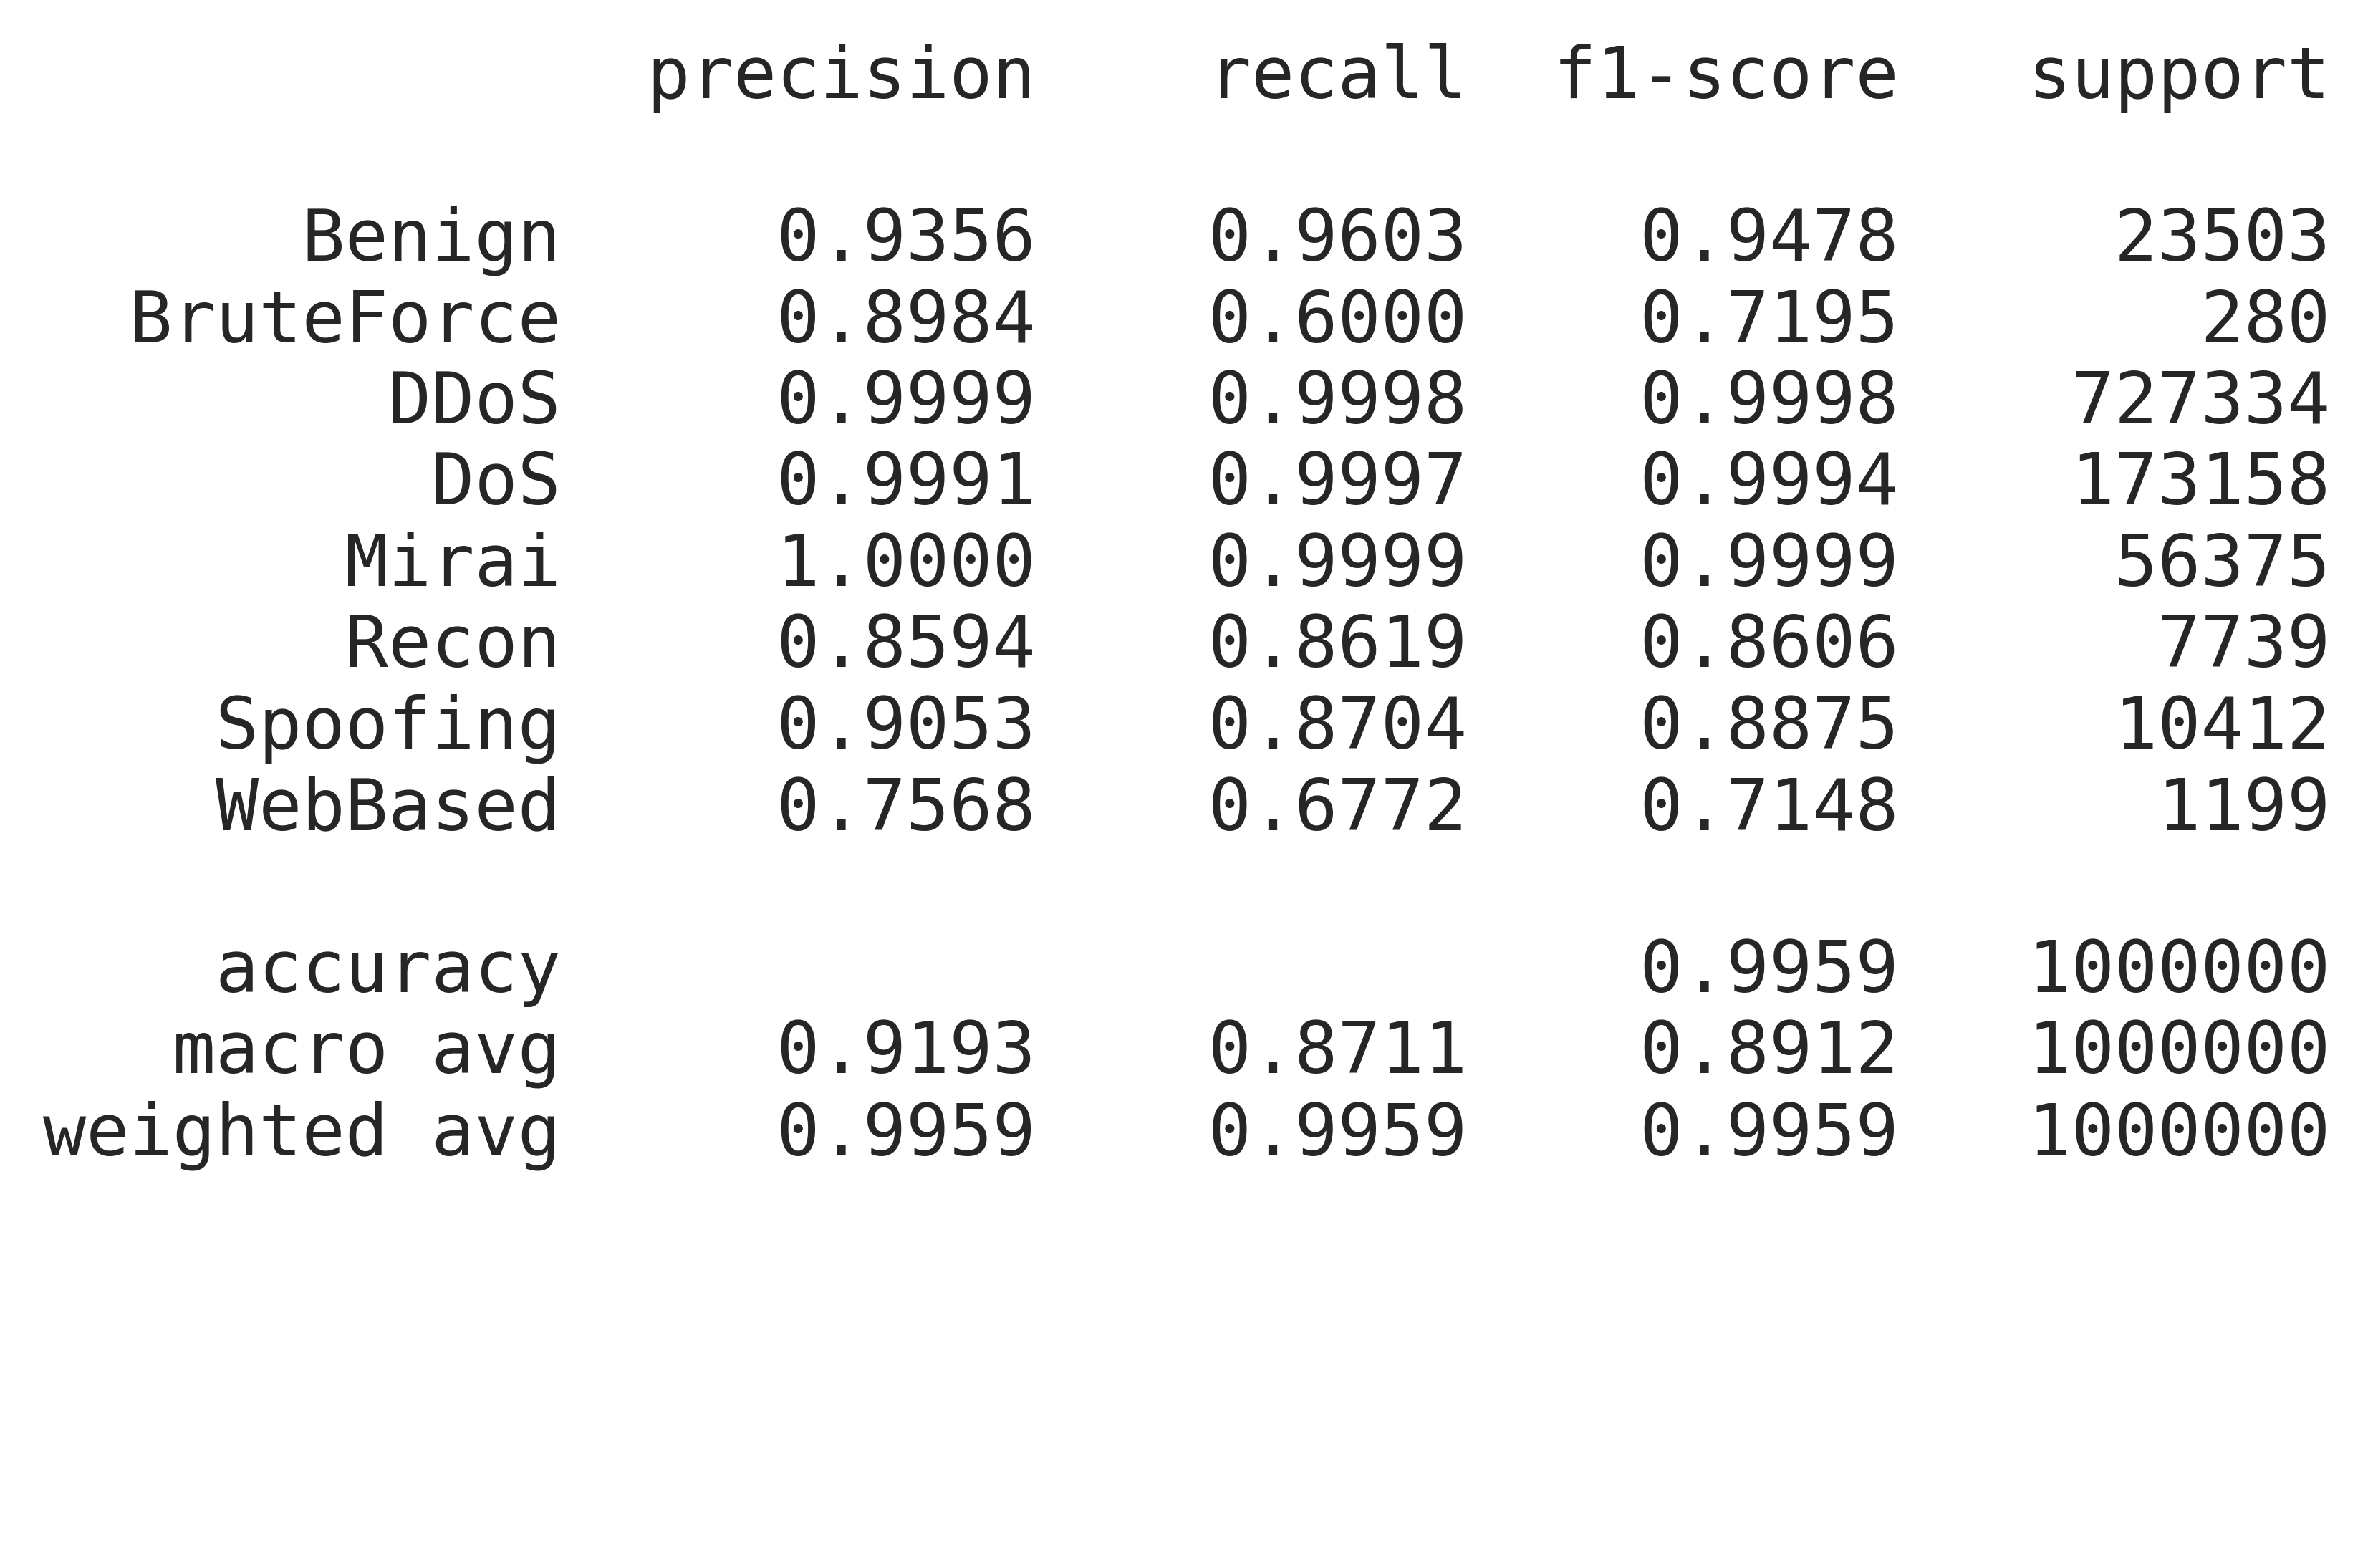

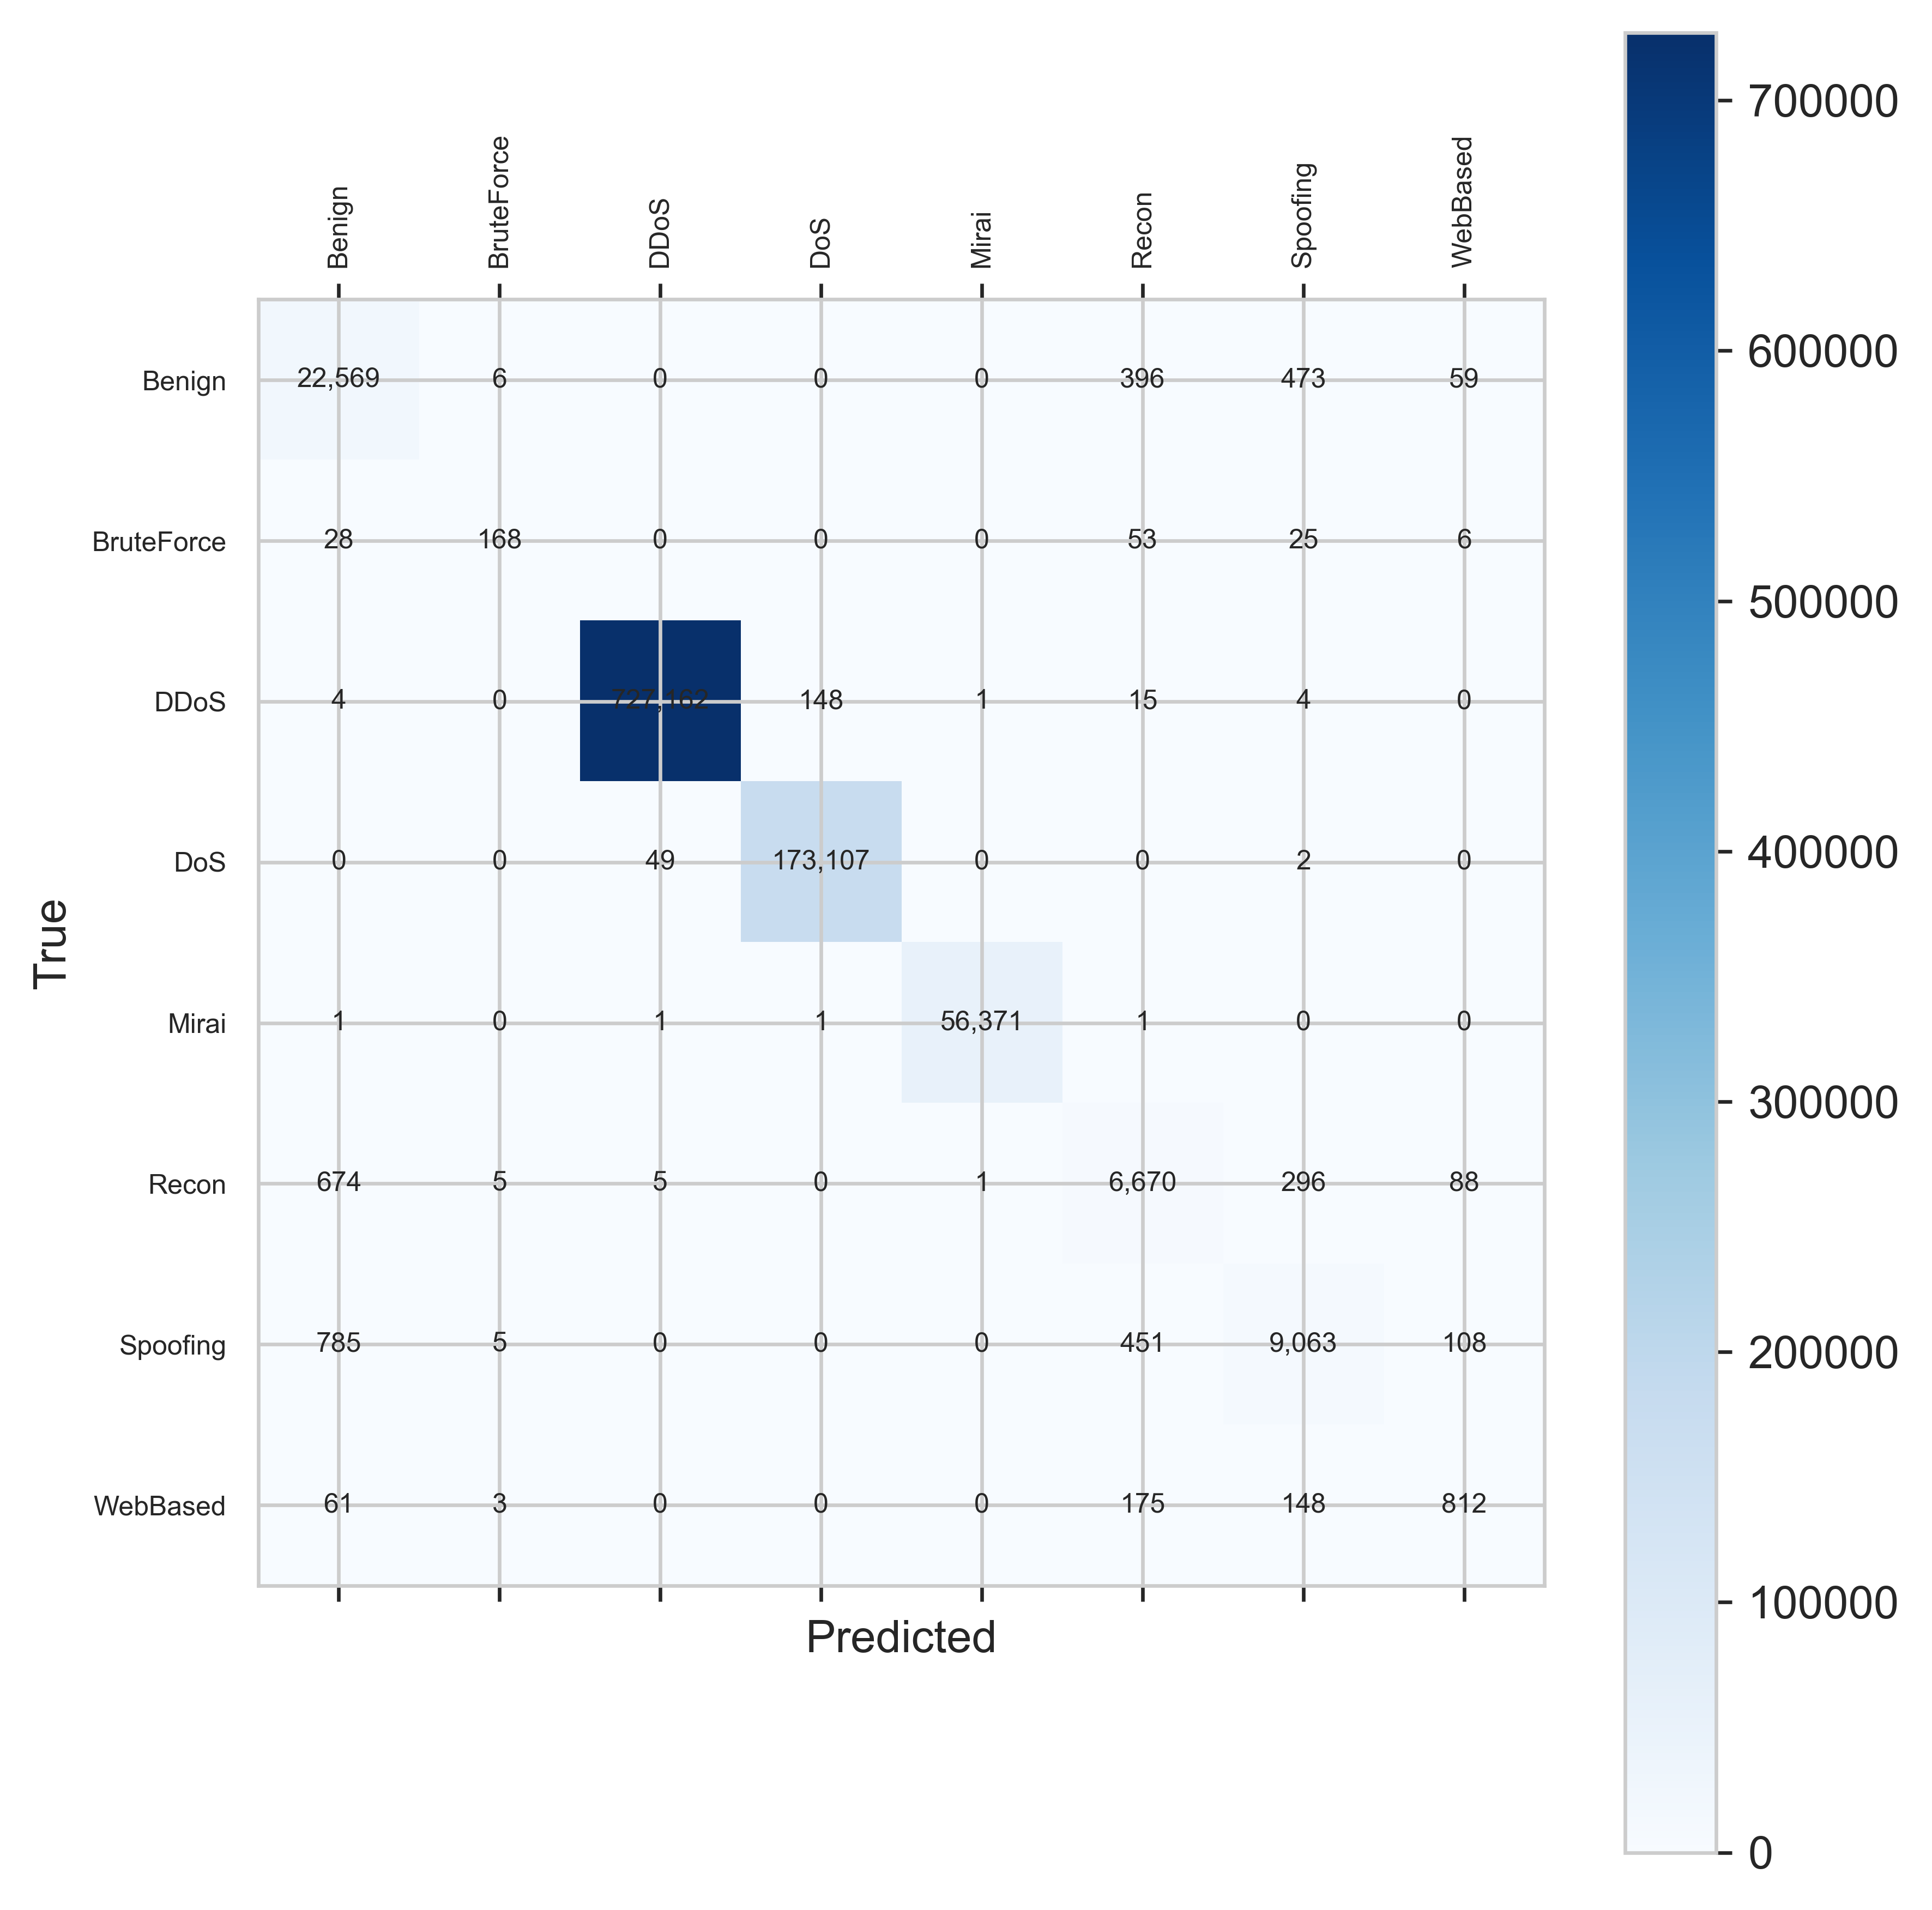

Training CatBoost...
0:	learn: 1.6797003	test: 1.4624566	best: 1.4624566 (0)	total: 163ms	remaining: 2m 42s
50:	learn: 0.4135489	test: 0.0602782	best: 0.0602782 (50)	total: 7.69s	remaining: 2m 23s
100:	learn: 0.3125663	test: 0.0439136	best: 0.0439136 (100)	total: 15.7s	remaining: 2m 19s
150:	learn: 0.2602889	test: 0.0364560	best: 0.0364560 (150)	total: 23.6s	remaining: 2m 12s
200:	learn: 0.2227948	test: 0.0289836	best: 0.0289836 (200)	total: 31.6s	remaining: 2m 5s
250:	learn: 0.1952181	test: 0.0267973	best: 0.0267973 (250)	total: 39.4s	remaining: 1m 57s
300:	learn: 0.1743726	test: 0.0248580	best: 0.0248580 (300)	total: 47.3s	remaining: 1m 49s
350:	learn: 0.1576913	test: 0.0236369	best: 0.0236369 (350)	total: 55.3s	remaining: 1m 42s
400:	learn: 0.1446137	test: 0.0226245	best: 0.0226245 (400)	total: 1m 3s	remaining: 1m 34s
450:	learn: 0.1325234	test: 0.0219026	best: 0.0219026 (450)	total: 1m 10s	remaining: 1m 26s
500:	learn: 0.1219785	test: 0.0212721	best: 0.0212721 (500)	total: 1m 18s	r

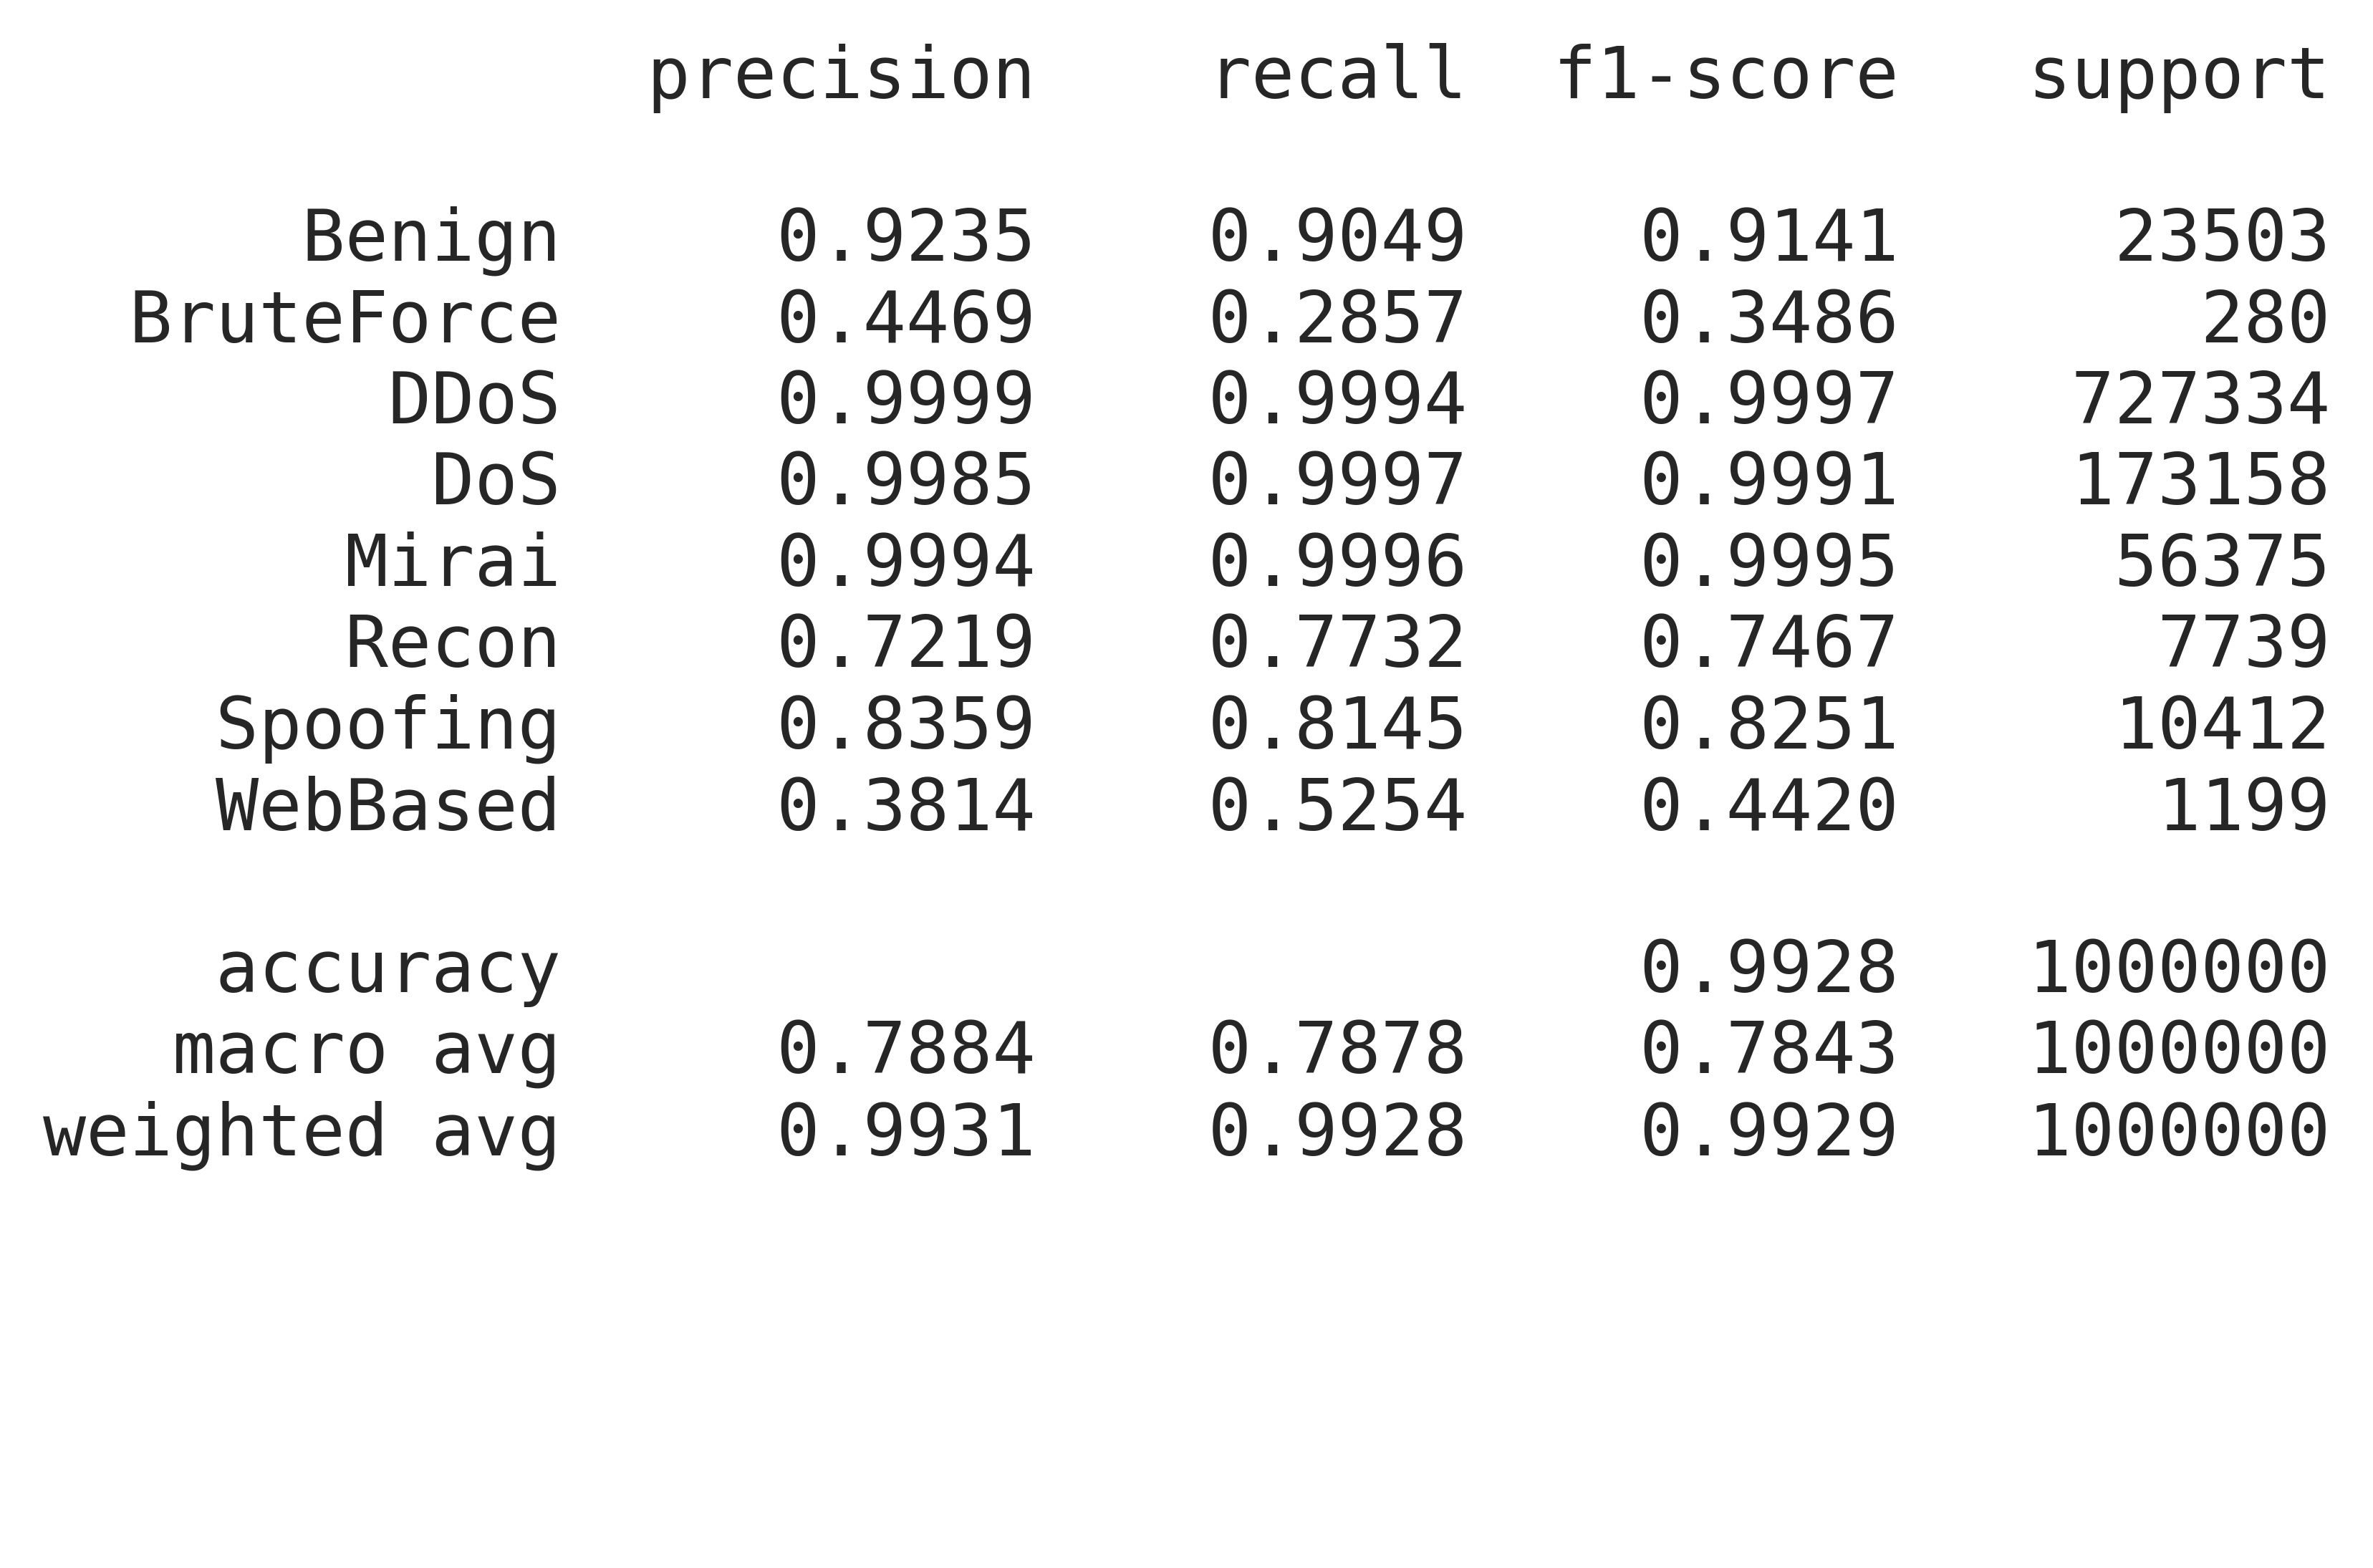

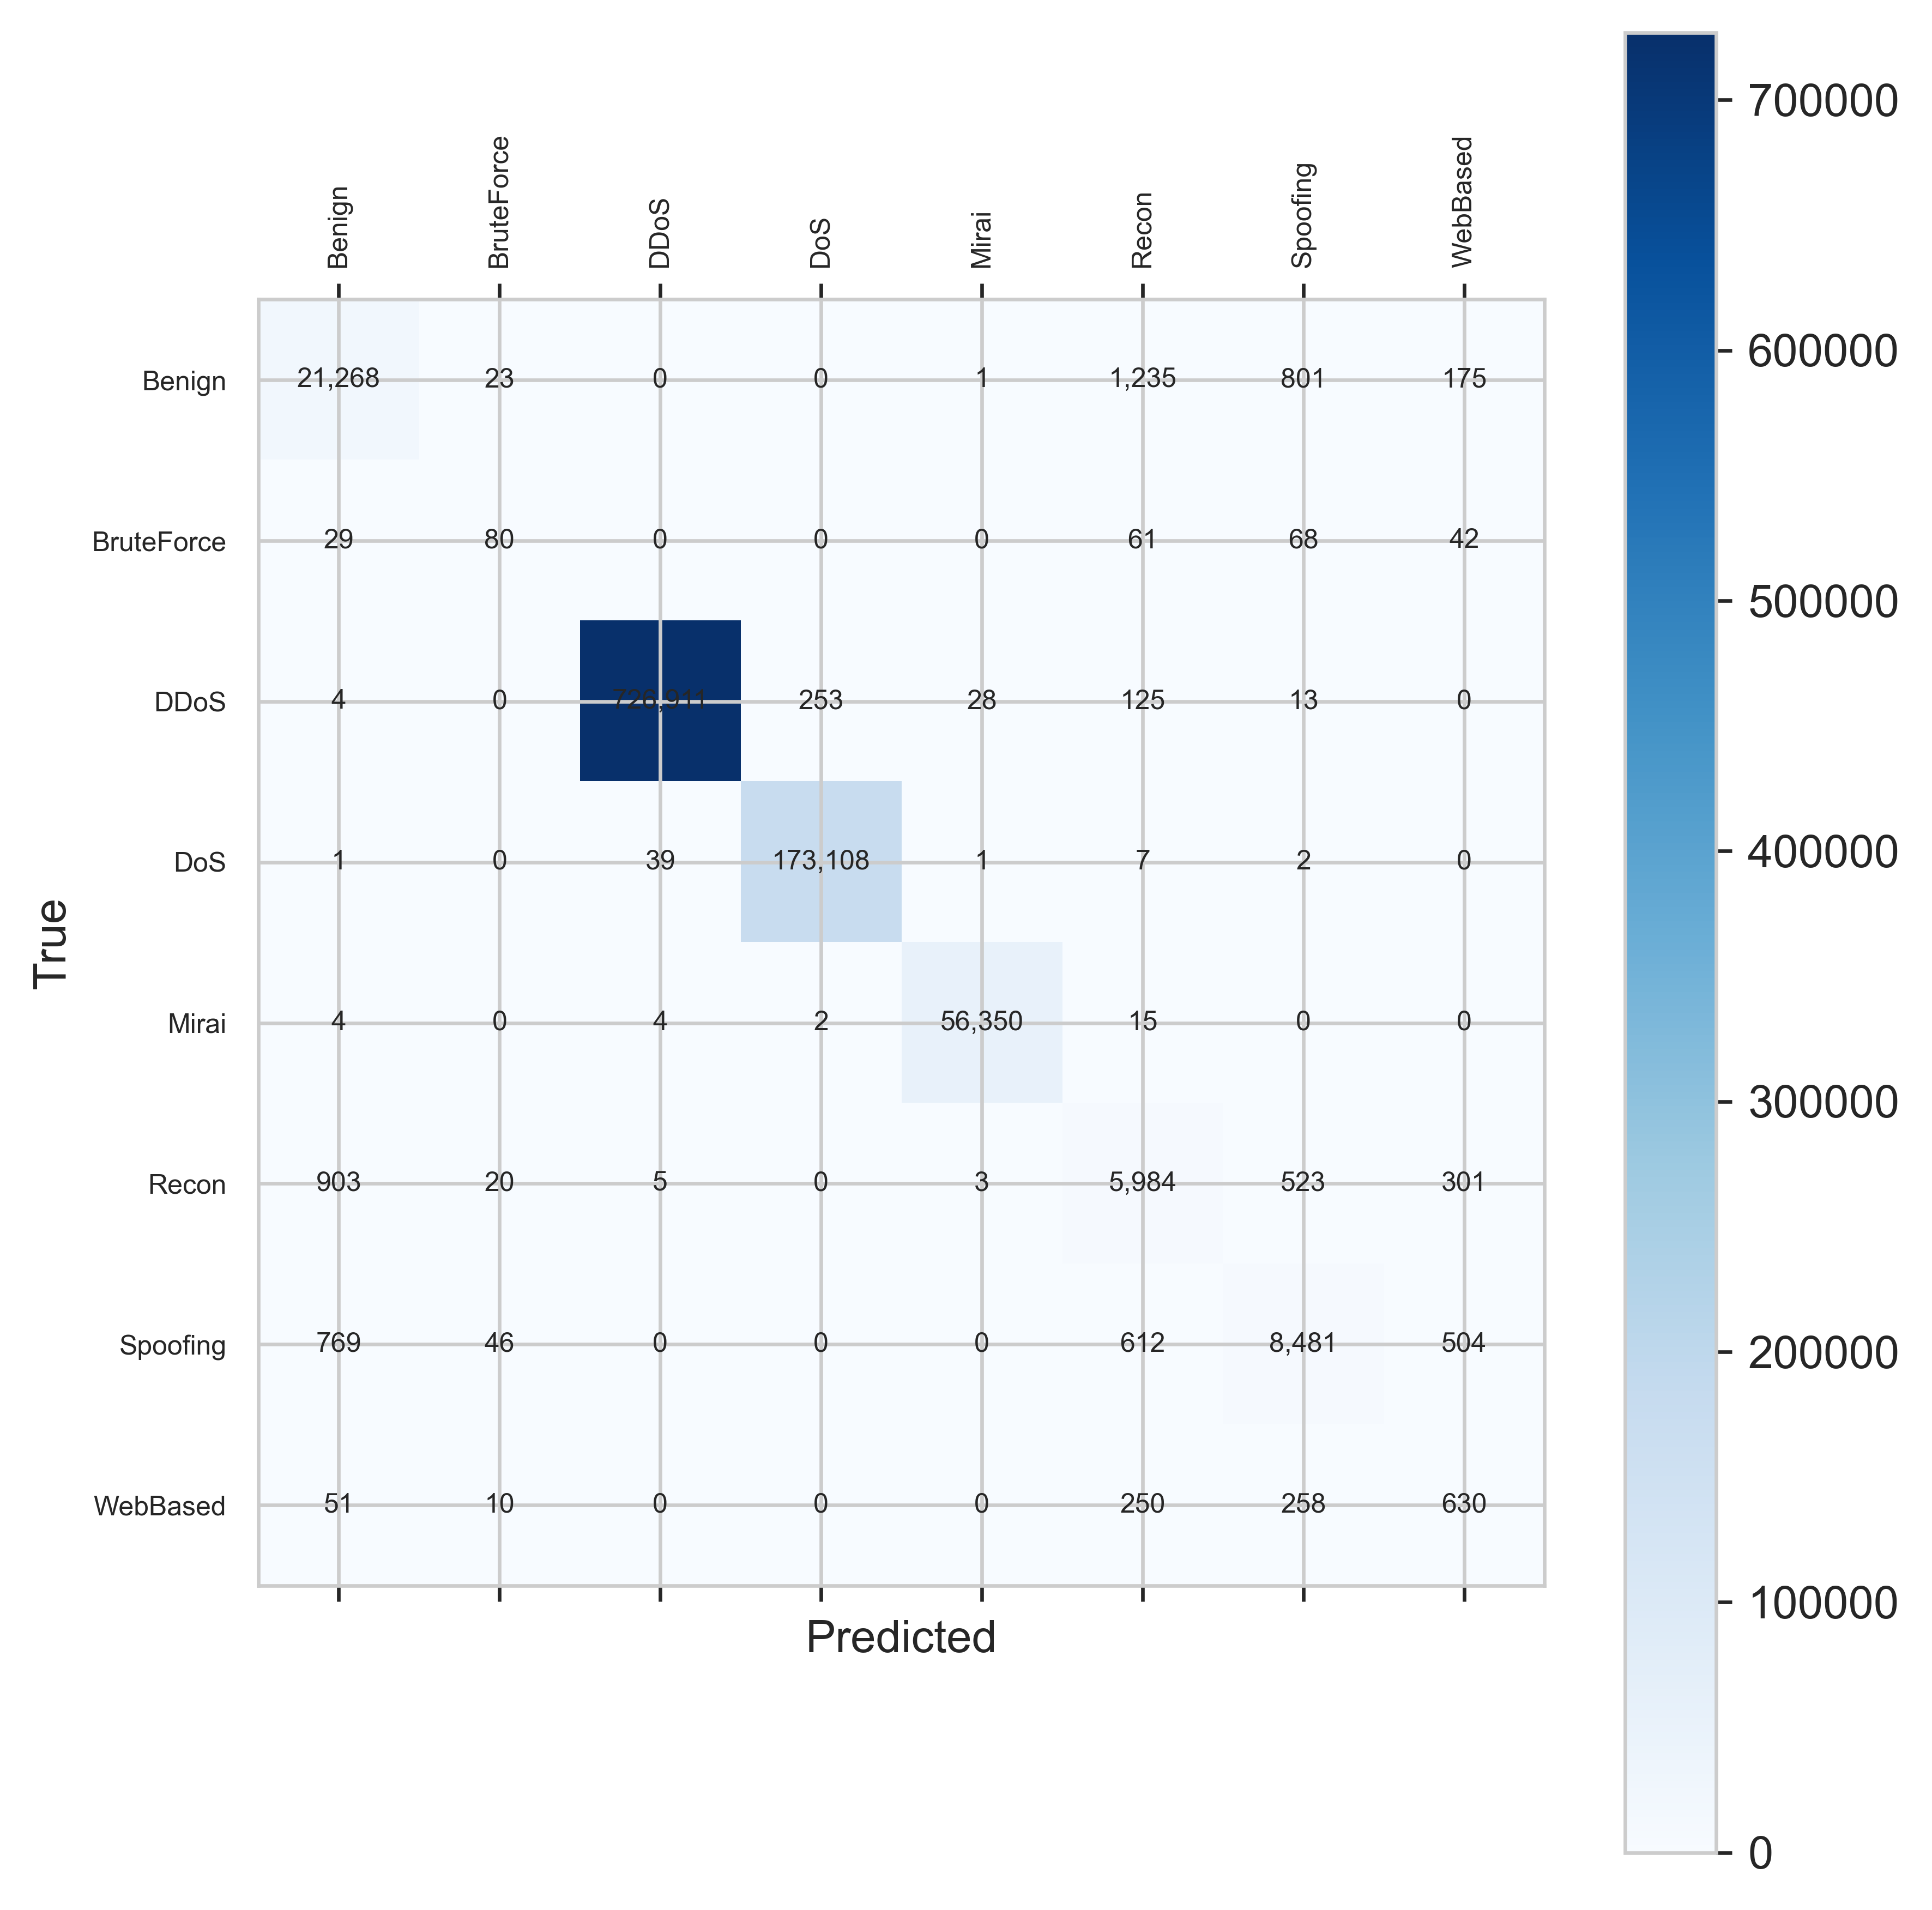

Training LightGBM...
Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.023495
[100]	valid_0's multi_logloss: 0.0197773
[150]	valid_0's multi_logloss: 0.0184032
[200]	valid_0's multi_logloss: 0.0175597
[250]	valid_0's multi_logloss: 0.0169904
[300]	valid_0's multi_logloss: 0.0165766
[350]	valid_0's multi_logloss: 0.0162526
[400]	valid_0's multi_logloss: 0.0160124
[450]	valid_0's multi_logloss: 0.0158255
[500]	valid_0's multi_logloss: 0.0156907
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.0156907


C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.993866
              precision    recall  f1-score   support

      Benign     0.9387    0.9227    0.9306     23503
  BruteForce     0.3164    0.3786    0.3447       280
        DDoS     0.9999    0.9998    0.9998    727334
         DoS     0.9992    0.9997    0.9995    173158
       Mirai     1.0000    0.9999    0.9999     56375
       Recon     0.8127    0.7997    0.8062      7739
    Spoofing     0.8563    0.8103    0.8327     10412
    WebBased     0.3604    0.6839    0.4721      1199

    accuracy                         0.9939   1000000
   macro avg     0.7855    0.8243    0.7982   1000000
weighted avg     0.9945    0.9939    0.9941   1000000



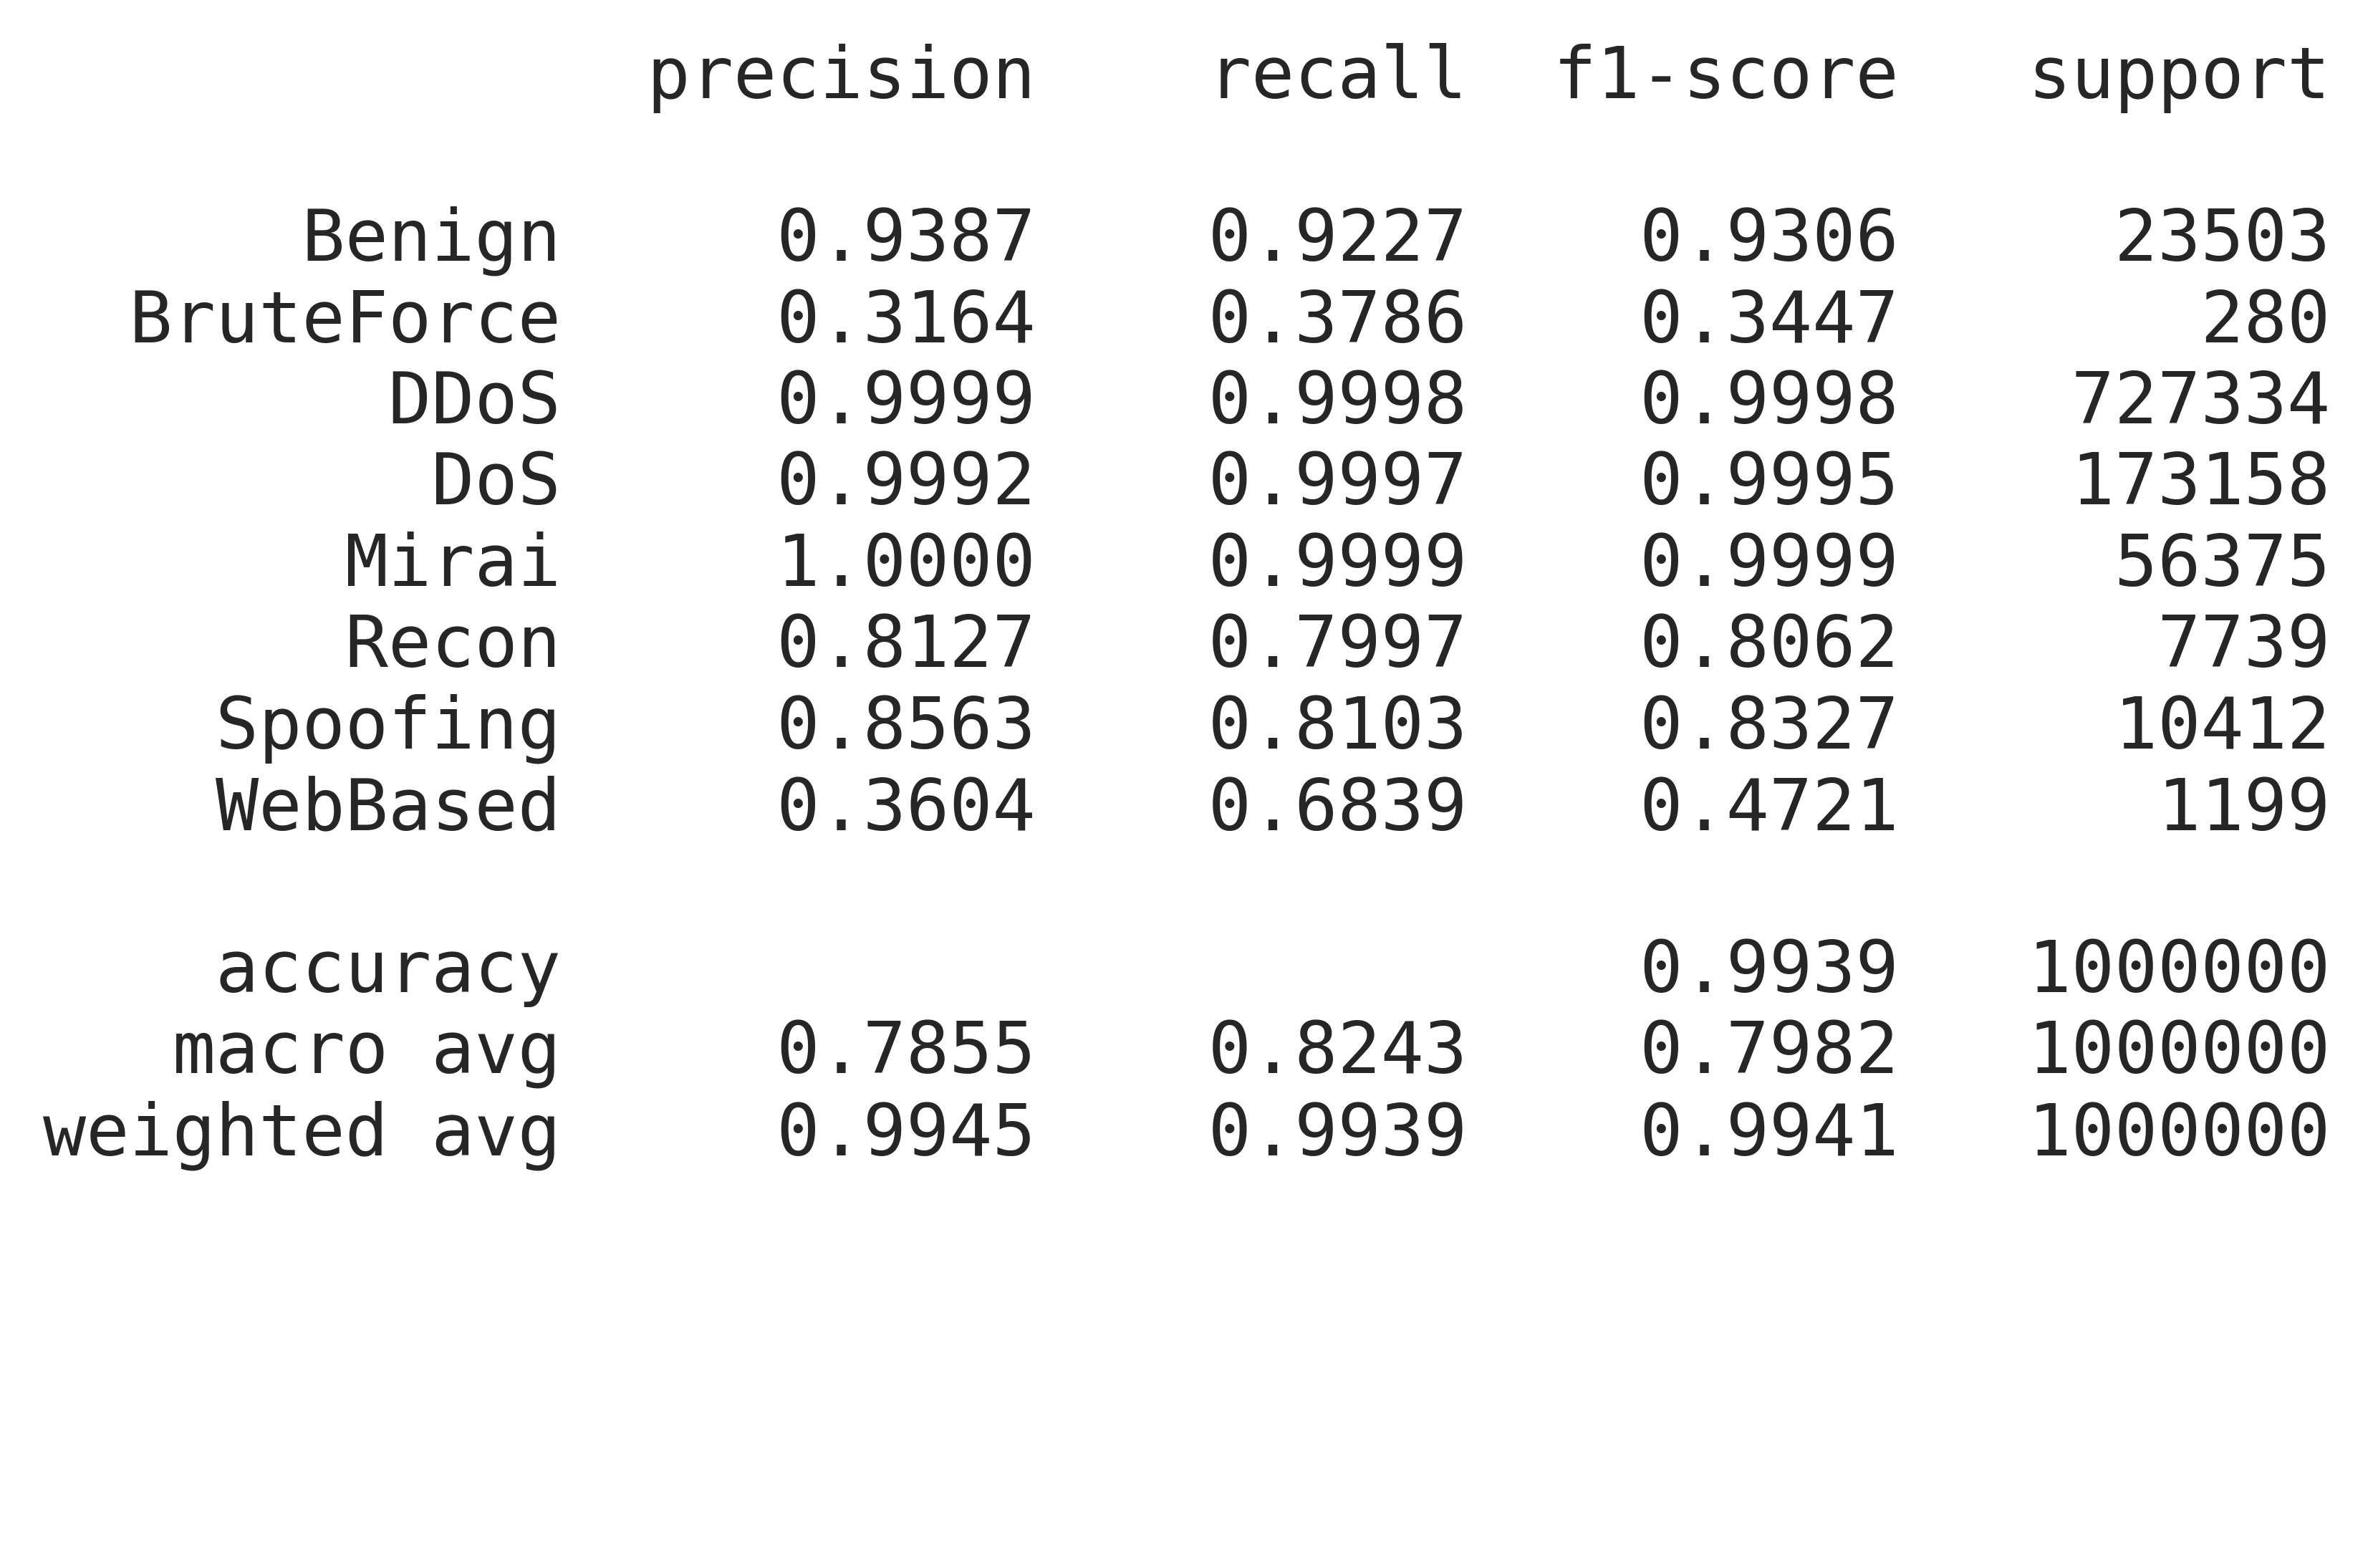

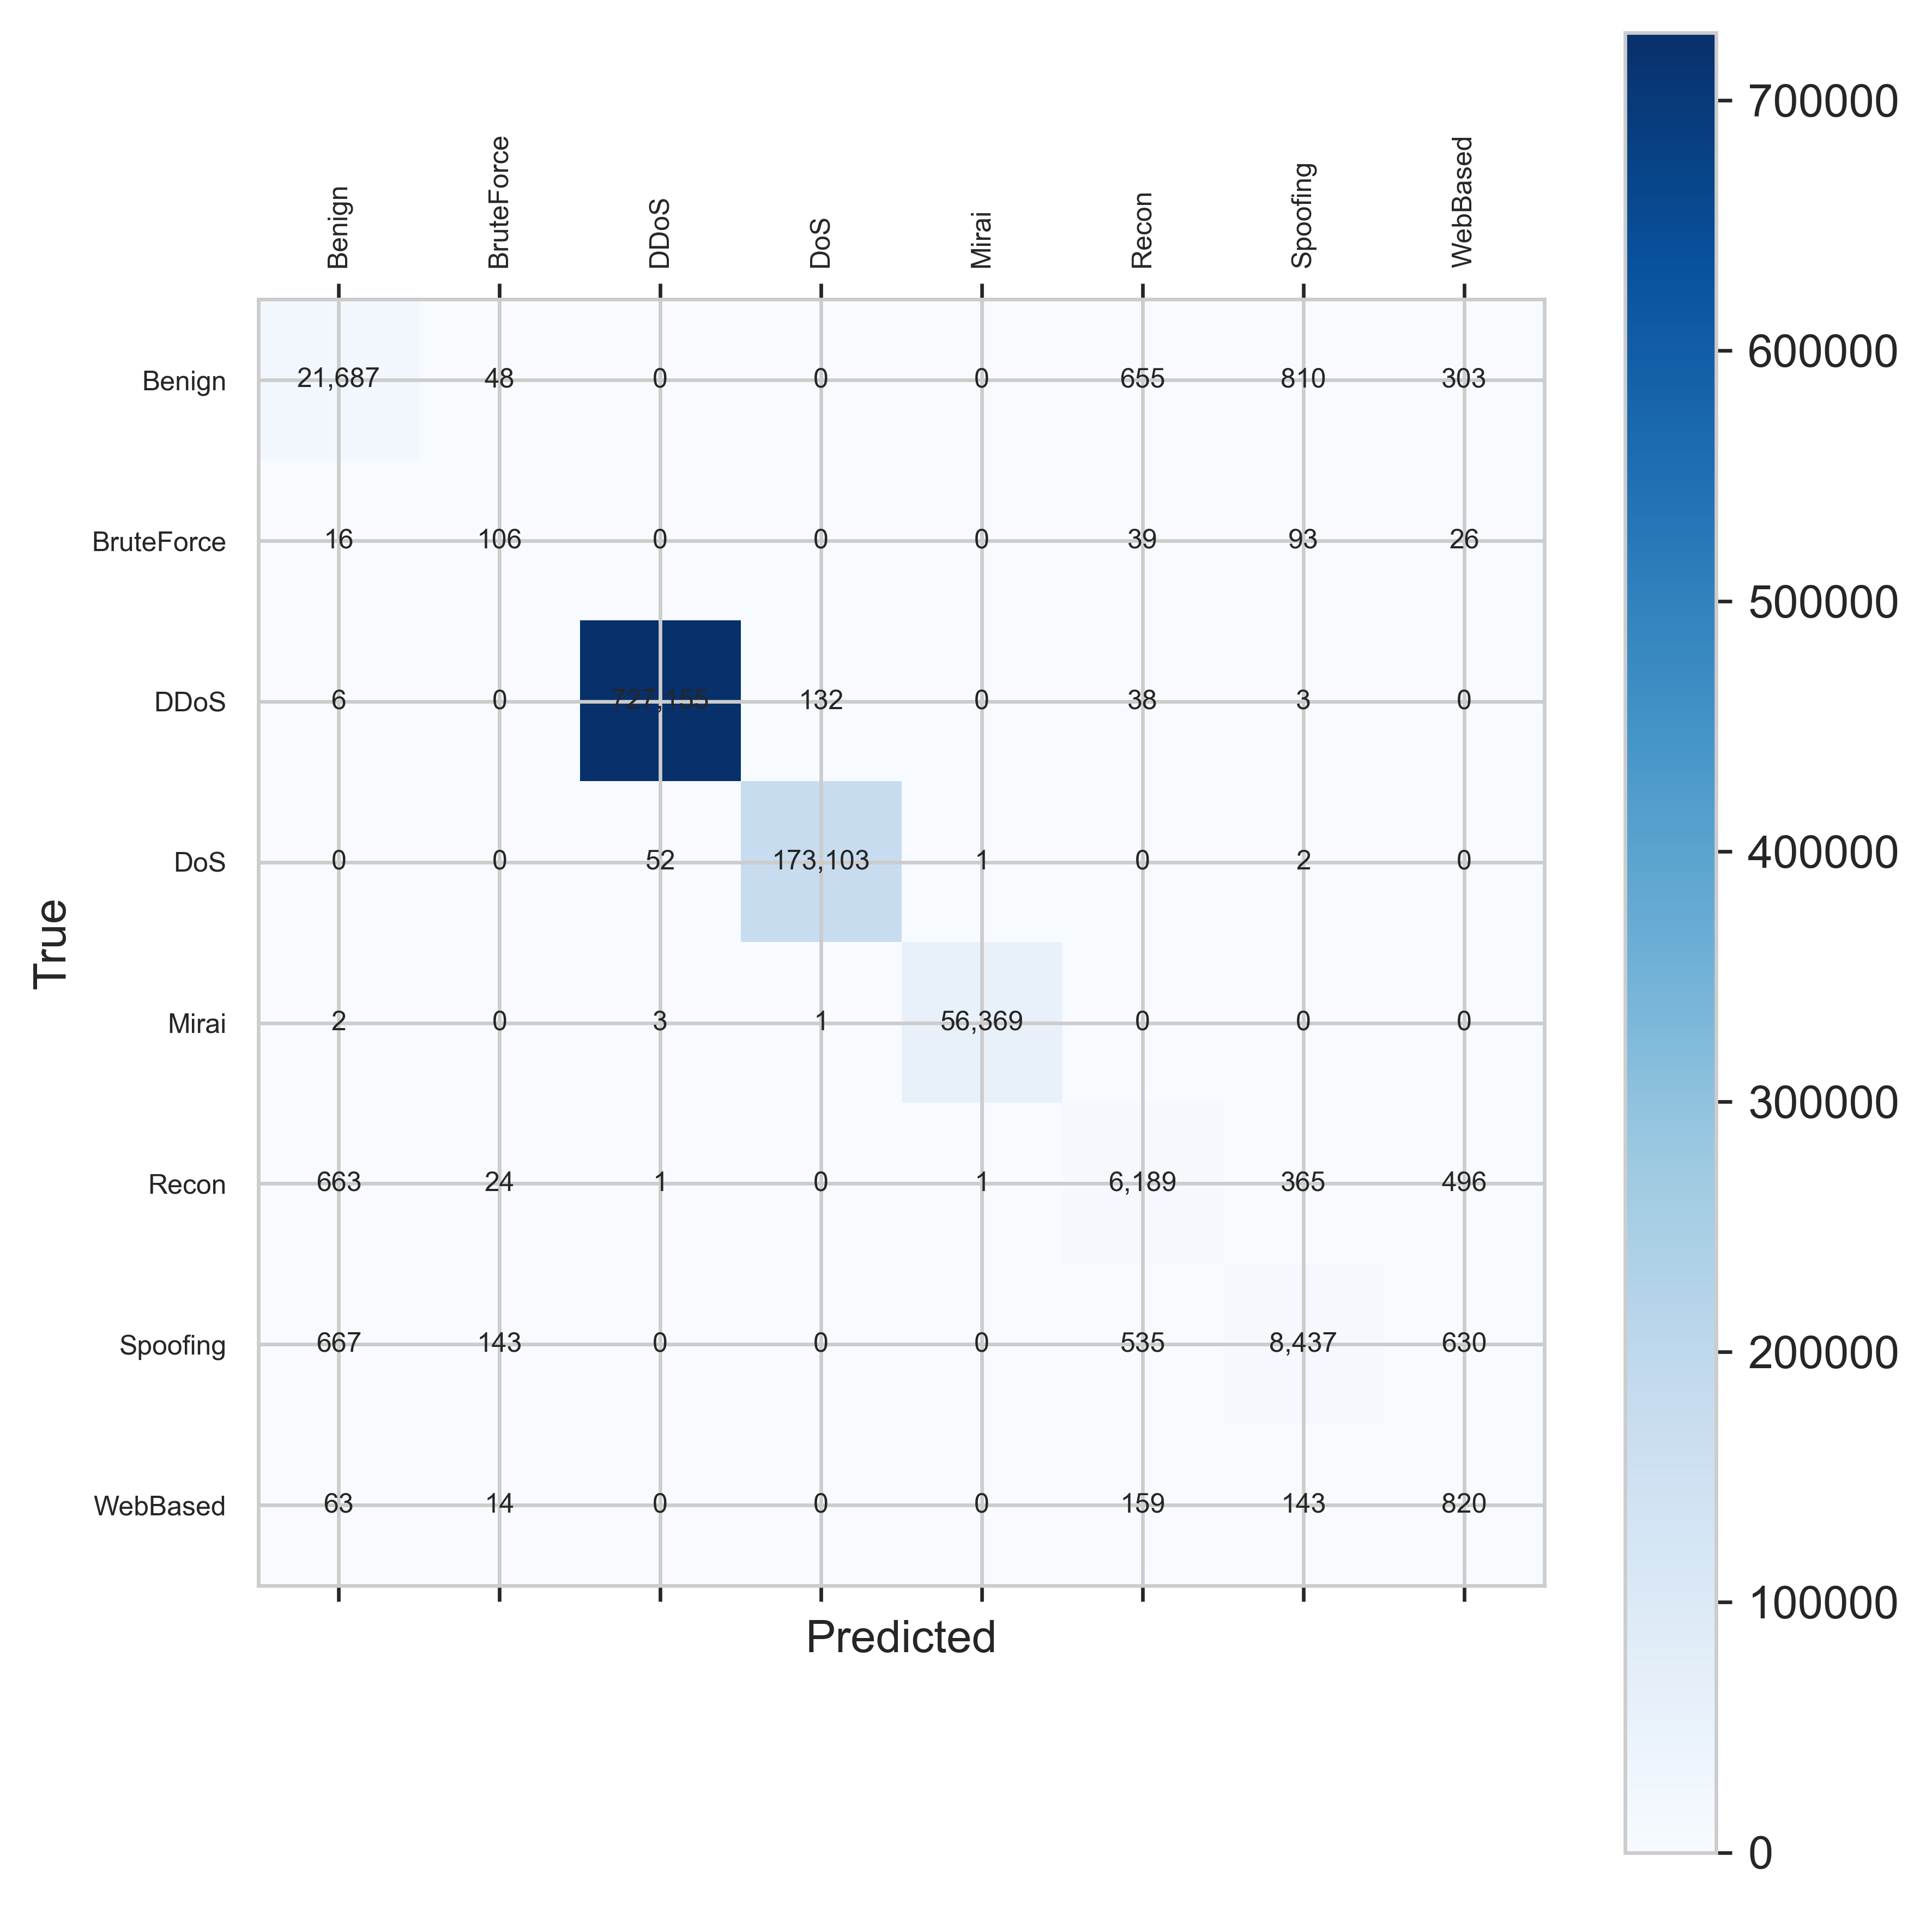

In [10]:


models = [
    ("XGBoost", xgb.XGBClassifier(
        device="cuda", predictor="gpu_predictor", n_estimators=500,
        learning_rate=0.1, max_depth=10, use_label_encoder=False,
        eval_metric="mlogloss", random_state=RANDOM_STATE
    )),
    ("CatBoost", CatBoostClassifier(
        iterations=500, learning_rate=0.1, depth=10,
        loss_function="MultiClass", eval_metric="MultiClass",
        task_type="GPU", random_seed=RANDOM_STATE, verbose=50
    )),
    ("LightGBM", lgb.LGBMClassifier(
        objective="multiclass", num_class=n_classes, n_estimators=500,
        learning_rate=0.1, max_depth=7, num_leaves=63, subsample=1.0,
        colsample_bytree=0.8, min_child_samples=300, min_split_gain=0.01,
        random_state=RANDOM_STATE
    ))
]

for name, model in models:
    print(f"Training {name}...")
    if name == "CatBoost":
        model.fit(X_train, y_train, sample_weight=wts, eval_set=(X_test, y_test))
    elif name == "LightGBM":
        model.fit(X_train, y_train, sample_weight=wts, eval_set=[(X_test, y_test)],
                  eval_metric="multi_logloss",
                  callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=50)])
    else:
        model.fit(X_train, y_train, sample_weight=wts, eval_set=[(X_test, y_test)], verbose=50)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc}")
    report = classification_report(y_test, y_pred, target_names=classes, digits=4)
    print(report)
    save_classification_report_as_image(report, name)
    cm = confusion_matrix(y_test, y_pred)
    save_confusion_matrix(cm, name, classes)
    joblib.dump(model, os.path.join(SAVE_DIR, f"{_sanitize_name(name)}_model.pkl"))

In [11]:
# ## 7. Latency Benchmark

def measure_inference_latency(model, X):
    _ = model.predict(X[:1])
    start = time.perf_counter()
    _ = model.predict(X)
    end = time.perf_counter()
    total_ms = (end - start) * 1000
    return total_ms, total_ms / X.shape[0]


for name, model in models:
    total, avg = measure_inference_latency(model, X_test)
    print(f"{name}: total={total:.2f} ms, per sample={avg:.4f} ms")

XGBoost: total=4040.93 ms, per sample=0.0040 ms
CatBoost: total=5452.45 ms, per sample=0.0055 ms


C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\ss160\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM: total=24691.86 ms, per sample=0.0247 ms
